## Imports and plot setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import sys
import seaborn as sns
import time
import numba
from numba import jit, prange

In [ ]:
my_pal = ['F4B393', '2F6690', '7FC97F', 'D972FF', 'CA1551', 'D58C2E', 'C9492C', '000000']
my_pal = [f"#{c}" for c in my_pal]

sns.reset_defaults() # useful when adjusting style a lot
plt.rcParams['font.family']=['sans-serif']
sns.set_theme(context="paper", style="ticks",
              # palette="Set2",
              palette=my_pal,
              rc={
              "pdf.fonttype": 42,  # embed font in output
              "svg.fonttype": "none",  # embed font in output
              "figure.facecolor": "white",
              "figure.dpi": 200,
              "axes.facecolor": "None",
              "axes.spines.left": True,
              "axes.spines.bottom": True,
              "axes.spines.right": False,
              "axes.spines.top": False,
          },
          )

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/aai/data/ml-32m/
#/content/MyDrive/MyDrive/Colab Notebooks/aai/ml-32m

/content/drive/MyDrive/Colab Notebooks/aai/data/ml-32m


In [ ]:
dir= "/content/drive/MyDrive/Colab Notebooks/aai/data/ml-32m/"
dir_data= "/content/drive/MyDrive/Colab Notebooks/aai/data/"

In [ ]:
#for running the 100k dataset, loads location
%cd /content/drive/MyDrive/Colab Notebooks/aai/data/ml-latest-small/

/content/drive/MyDrive/Colab Notebooks/aai/data/ml-latest-small


In [ ]:
#!wget https://files.grouplens.org/datasets/movielens/ml-32m.zip
#!unzip ml-32m.zip

Archive:  ml-32m.zip
   creating: ml-32m/
  inflating: ml-32m/tags.csv         
  inflating: ml-32m/links.csv        
  inflating: ml-32m/README.txt       
  inflating: ml-32m/checksums.txt    
  inflating: ml-32m/ratings.csv      
  inflating: ml-32m/movies.csv       


In [ ]:
#!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
#!unzip  ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Custom Data structure loading, converting to coo arrary, loading movie and genres list and polarizing plot check

In [ ]:
# with train_test split
ratings_users = []
ratings_movies = []
ratings_ratings = []

split_ratio = 0.9
user_dict = {}
inv_user_dict = {}

movie_dict = {}
inv_movie_dict ={}
user_index_train = []
movie_index_train = []

#test versions
user_index_test =[]
movie_index_test =[]

# Separate counters for unique users and movies
n_users = 0
n_movies = 0

with open('ratings.csv') as data:
    ratings_data = csv.reader(data)
    header = next(ratings_data)

    for i, rating in enumerate(ratings_data):
        user_id = rating[0]
        movie_id = rating[1]
        rating_val = float(rating[2])
        random = np.random.random()

        # Store raw data
        #ratings_users.append(int(user_id))
        #ratings_movies.append(int(movie_id))
        #ratings_ratings.append(rating_val)

        # Handle user indexing
        if user_id in user_dict:
          # User exists - get their index
          user_idx = user_dict[user_id]
        else:
          # New user - assign next index
          user_idx = n_users
          user_dict[user_id] = user_idx
          inv_user_dict[user_idx] = user_id
          user_index_train.append([])  # Add new empty list for this user
          user_index_test.append([])
          n_users += 1


        # Handle movie indexing
        if movie_id in movie_dict:
            movie_idx = movie_dict[movie_id]
        else:
            # New movie - assign next index
            movie_idx = n_movies
            movie_dict[movie_id] = movie_idx
            inv_movie_dict[movie_idx]=movie_id
            movie_index_train.append([])  # Add new empty list for this movie
            movie_index_test.append([])
            n_movies += 1

        if random < split_ratio:
          movie_index_train[movie_idx].append([int(user_id), rating_val])
          user_index_train[user_idx].append([int(movie_id), rating_val])

        else:
          movie_index_test[movie_idx].append([int(user_id), rating_val])
          user_index_test[user_idx].append([int(movie_id), rating_val])






        #if i == 100000:
        #    break

print(f"Loaded {i+1} ratings")
print(f"Unique users: {n_users}")
print(f"Unique movies: {n_movies}")
print(f"Example - User {list(user_dict.keys())[0]} (index {user_dict[list(user_dict.keys())[0]]}): {user_index_train[0][:3]}{user_index_test[0][:3]}")

Loaded 32000204 ratings
Unique users: 200948
Unique movies: 84432
Example - User 1 (index 0): [[17, 4.0], [25, 1.0], [29, 2.0]][[36, 1.0], [161, 1.0], [306, 5.0]]


### converting to coo arrays


In [ ]:
def convert_to_numba_arrays(nested_list):
    """
    Converts a list of lists [[(id, rating), ...], ...]
    into the 3-array format (indptr, indices, data) required for Numba.
    """
    # 1. Create INDPTR (The "Bookmarks")
    indptr = np.cumsum([0] + [len(sublist) for sublist in nested_list], dtype=np.int32)

    # 2. Flatten the Data
    flat_list = [item for sublist in nested_list for item in sublist]

    if not flat_list:
        return indptr, np.array([], dtype=np.int32), np.array([], dtype=np.float64)

    # 3. Convert to NumPy and Split
    flat_arr = np.array(flat_list)
    indices = flat_arr[:, 0].astype(np.int32)
    data = flat_arr[:, 1].astype(np.float64)

    return indptr, indices, data


In [ ]:
print("Converting to Numba arrays...")

# Convert all datasets
train_users_indptr, train_users_indices, train_users_data = convert_to_numba_arrays(user_index_train)
train_movies_indptr, train_movies_indices, train_movies_data = convert_to_numba_arrays(movie_index_train)
test_users_indptr, test_users_indices, test_users_data = convert_to_numba_arrays(user_index_test)
test_movies_indptr, test_movies_indices, test_movies_data = convert_to_numba_arrays(movie_index_test)

print("Conversion Complete.")

Converting to Numba arrays...
Conversion Complete.


### movie and genres loading

In [ ]:

movie_titles = [""] * n_movies
genres = [""] * n_movies

print(f"Loading movie titles and genres for {n_movies} movies...")
csv.field_size_limit(sys.maxsize)


with open("movies.csv", mode='r', encoding='utf-8') as movies_file:
    movie_reader = csv.reader(movies_file)

    header = next(movie_reader)
    for row in movie_reader:
      movie_id_str = row[0]
      title = row[1]
      genre_list = row[2].split('|')

      m_idx = movie_dict.get(movie_id_str)

      if m_idx is not None:
          movie_titles[m_idx] = title
          genres[m_idx] = genre_list



print("Successfully loaded movie titles and genres.")




Loading movie titles and genres for 84432 movies...
Successfully loaded movie titles and genres.


#### 'polarizing movie' ratings check

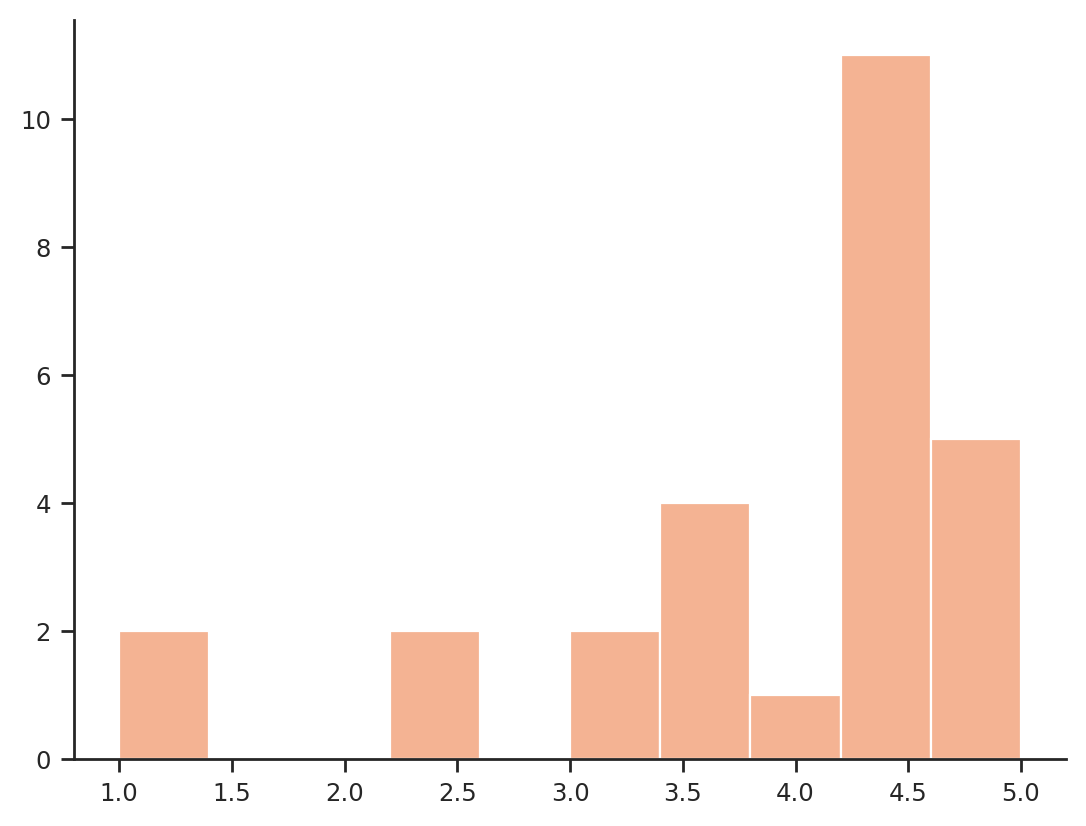

In [ ]:
temp = []
# temp.append(movie_index_train[23930])
a=movie_index_test[23930]
b= movie_index_train[23930]
# temp.append(movie_index_test[23930])
# len(movie_index_train[23930])+len(movie_index_test[23930])
for i in a:
  temp.append(i[1])

for i in b:
  temp.append(i[1])

plt.hist(temp)

plt.savefig('/content/drive/MyDrive/Colab Notebooks/aai/plots/polarize.pdf',dpi=500, format='pdf')
plt.show()

In [ ]:
genres

[['Drama', 'Romance'],
 ['Drama', 'Romance'],
 ['Adventure', 'Drama', 'Fantasy', 'Mystery', 'Sci-Fi'],
 ['Crime', 'Drama'],
 ['Mystery', 'Sci-Fi', 'Thriller'],
 ['Children', 'Drama'],
 ['Crime', 'Drama'],
 ['Children', 'Drama'],
 ['Action', 'Drama', 'War'],
 ['Crime', 'Drama', 'Thriller'],
 ['Drama', 'Thriller', 'War'],
 ['Comedy', 'Crime', 'Drama'],
 ['Comedy'],
 ['Comedy'],
 ['Comedy', 'Drama', 'Romance'],
 ['Action', 'Adventure', 'Sci-Fi'],
 ['Drama', 'Romance'],
 ['Drama'],
 ['Drama'],
 ['Comedy', 'Drama'],
 ['Comedy', 'Drama'],
 ['Comedy', 'Drama', 'Romance', 'War'],
 ['Drama', 'War'],
 ['Action', 'Sci-Fi', 'Thriller'],
 ['Comedy', 'Drama'],
 ['Crime', 'Horror', 'Thriller'],
 ['Comedy', 'Crime', 'Drama', 'Thriller'],
 ['Drama'],
 ['Drama', 'Mystery', 'Western'],
 ['Drama'],
 ['Comedy', 'Drama', 'Romance'],
 ['Action', 'Adventure', 'Mystery', 'Romance', 'Thriller'],
 ['Comedy', 'Drama', 'Romance'],
 ['Drama', 'Romance'],
 ['Comedy', 'Romance'],
 ['Comedy', 'Drama', 'Romance'],
 ['D

### Data saving and loading

In [ ]:
# loading only works with more than 15 gb of ram
save_dir_100 = "/content/drive/MyDrive/Colab Notebooks/aai/data/ml-latest-small/ratings_data.npz"
save_dir_32 = "/content/drive/MyDrive/Colab Notebooks/aai/data/ml-32m/ratings_data.npz"

In [ ]:

np.savez_compressed(
    save_dir_32,
    user_dict_keys=np.array(list(user_dict.keys())),
    user_dict_values=np.array(list(user_dict.values())),
    inv_user_dict_keys=np.array(list(inv_user_dict.keys())),
    inv_user_dict_values=np.array(list(inv_user_dict.values())),
    movie_dict_keys=np.array(list(movie_dict.keys())),
    movie_dict_values=np.array(list(movie_dict.values())),
    inv_movie_dict_keys=np.array(list(inv_movie_dict.keys())),
    inv_movie_dict_values=np.array(list(inv_movie_dict.values())),
    user_index_train=np.array(user_index_train, dtype=object),
    user_index_test=np.array(user_index_test, dtype=object),
    movie_index_train=np.array(movie_index_train, dtype=object),
    movie_index_test=np.array(movie_index_test, dtype=object),
    metadata=np.array([n_users, n_movies, split_ratio])
)

print(f" All data saved to {save_dir_32}")

✓ All data saved to ratings_data.npz


In [ ]:
#for 100k
data = np.load(save_dir_100, allow_pickle=True)

user_dict = dict(zip(data['user_dict_keys'], data['user_dict_values']))
inv_user_dict = dict(zip(data['inv_user_dict_keys'], data['inv_user_dict_values']))
movie_dict = dict(zip(data['movie_dict_keys'], data['movie_dict_values']))
inv_movie_dict = dict(zip(data['inv_movie_dict_keys'], data['inv_movie_dict_values']))

user_index_train = data['user_index_train'].tolist()
user_index_test = data['user_index_test'].tolist()
movie_index_train = data['movie_index_train'].tolist()
movie_index_test = data['movie_index_test'].tolist()

n_users = int(data['metadata'][0])
n_movies = int(data['metadata'][1])
split_ratio = float(data['metadata'][2])

In [ ]:
# to flatten data
#list = [item for x in nested list for item in sublist]
[item for sublist in movie_index_train for item in sublist]

[[1, 4.0],
 [5, 4.0],
 [7, 4.5],
 [15, 2.5],
 [21, 3.5],
 [27, 3.0],
 [31, 5.0],
 [32, 3.0],
 [33, 3.0],
 [40, 5.0],
 [44, 3.0],
 [45, 4.0],
 [46, 5.0],
 [50, 3.0],
 [54, 3.0],
 [57, 5.0],
 [63, 5.0],
 [64, 4.0],
 [66, 4.0],
 [68, 2.5],
 [71, 5.0],
 [73, 4.5],
 [76, 0.5],
 [78, 4.0],
 [82, 2.5],
 [86, 4.0],
 [89, 3.0],
 [90, 3.0],
 [91, 4.0],
 [93, 3.0],
 [96, 5.0],
 [98, 4.5],
 [103, 4.0],
 [107, 4.0],
 [112, 3.0],
 [119, 3.5],
 [121, 4.0],
 [124, 4.0],
 [130, 3.0],
 [132, 2.0],
 [134, 3.0],
 [135, 4.0],
 [137, 4.0],
 [141, 4.0],
 [144, 3.5],
 [145, 5.0],
 [151, 5.0],
 [153, 2.0],
 [155, 3.0],
 [156, 4.0],
 [159, 4.5],
 [160, 4.0],
 [166, 5.0],
 [167, 3.5],
 [169, 4.5],
 [171, 5.0],
 [177, 5.0],
 [178, 4.0],
 [179, 4.0],
 [185, 4.0],
 [186, 4.0],
 [191, 4.0],
 [193, 2.0],
 [200, 3.5],
 [201, 5.0],
 [202, 4.0],
 [206, 5.0],
 [213, 3.5],
 [214, 3.0],
 [216, 3.0],
 [217, 4.0],
 [219, 3.5],
 [220, 5.0],
 [223, 3.5],
 [229, 5.0],
 [232, 3.5],
 [233, 3.0],
 [234, 5.0],
 [239, 4.0],
 [247, 5

## Trainging and evaluation testing

### Initial Bias training


In [ ]:
train_rmse=[]
test_rmse=[]
train_loss= []
test_loss =[]

# initialize biases and global mean
user_bias = np.zeros(n_users)
movie_bias = np.zeros(n_movies)



# regularization
lambda_reg = 1
gamma = 0.1
n_epochs = 5

for epoch in range(n_epochs):
    # update user biases
    for u in range(n_users):
        ratings = user_index_train[u]
        if not ratings:
            continue
        # sum of (r_ui - global_mean - b_i)
        u_bias = 0.0
        item_counter = 0 #movies
        for m_id, r in ratings:
            m_idx = movie_dict[str(m_id)]
            u_bias += (r - movie_bias[m_idx])
            item_counter += 1
        user_bias[u] = lambda_reg*u_bias / (lambda_reg* item_counter + gamma)

    # update movie biases
    for m in range(n_movies):
        ratings = movie_index_train[m]
        if not ratings:
            continue
        m_bias = 0.0
        user_counter = 0.0
        for u_id, r in ratings:
            u_idx = user_dict[str(u_id)]
            m_bias += (r - user_bias[u_idx])
            user_counter += 1
        movie_bias[m] = lambda_reg*m_bias / (lambda_reg*user_counter + gamma)




    # compute training RMSE for monitoring
    #combine both
    train_error = 0
    test_error = 0
    train_count = 0
    test_count = 0

    for i in range(n_users):
      for m_id, r in user_index_train[u]:
        u_idx = movie_dict[str(m_id)]
        train_error += (r - (user_bias[u] + movie_bias[u_idx]))**2
        train_count += 1

      for m_id, r in user_index_test[u]:
        m_idx = movie_dict[str(m_id)]
        #pred = user_bias[u] + movie_bias[m_idx]
        test_error += (r - (user_bias[u] + movie_bias[m_idx]))**2
        test_count += 1

    rmse_train = np.sqrt(train_error/train_count)
    loss_train = -0.5* lambda_reg*(train_error)- 0.5*gamma*(np.sum(user_bias**2) + np.sum(movie_bias**2))

    rmse_test = np.sqrt(test_error/test_count)
    loss_test = -0.5* lambda_reg*(test_error)- 0.5*gamma*(np.sum(user_bias**2) + np.sum(movie_bias**2))

    train_rmse.append(rmse_train)
    test_rmse.append(rmse_test)

    train_loss.append(loss_train)
    test_loss.append(loss_test)
    print(f"Epoch {epoch+1} of {n_epochs} | Train RMSE: {rmse_train:.5f}, Test RMSE: {rmse_test:.5f}. Train Loss: {loss_train:.5f}, Test Loss {loss_test:.5f}")





Epoch 1 of 5 | Train RMSE: 1.06097, Test RMSE: 1.17953. Train Loss: -24345061.34343, Test Loss -3217028.74525
Epoch 2 of 5 | Train RMSE: 1.03726, Test RMSE: 1.18322. Train Loss: -23271705.19609, Test Loss -3232842.04084
Epoch 3 of 5 | Train RMSE: 1.03442, Test RMSE: 1.18332. Train Loss: -23144491.48755, Test Loss -3232656.06511
Epoch 4 of 5 | Train RMSE: 1.03377, Test RMSE: 1.18331. Train Loss: -23115284.23640, Test Loss -3232369.41756
Epoch 5 of 5 | Train RMSE: 1.03360, Test RMSE: 1.18333. Train Loss: -23107658.87058, Test Loss -3232256.39251


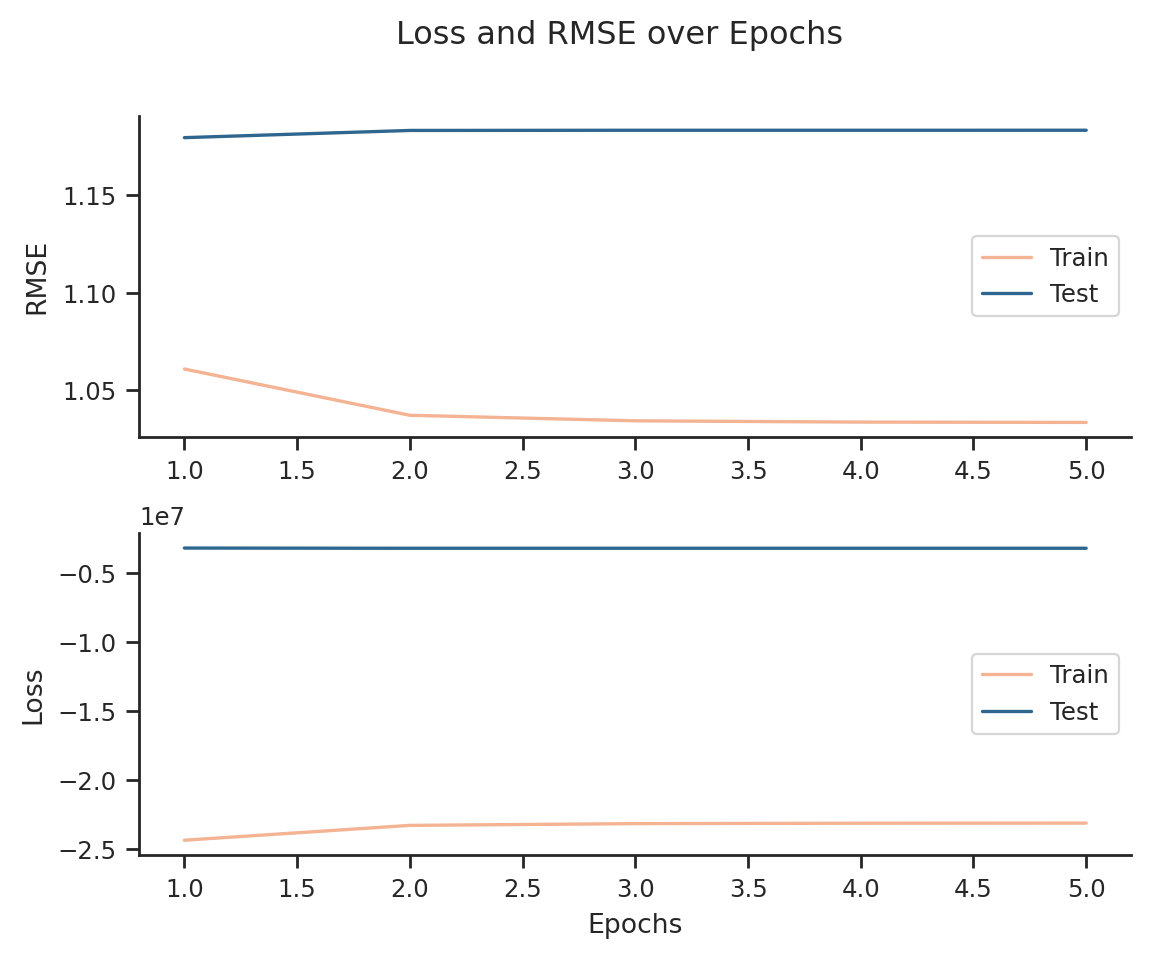

In [ ]:
#plots
fig, axes = plt.subplot_mosaic(
    [
        ["rmse"],
        ["loss"]
    ],
    gridspec_kw=dict(hspace=0.3,wspace=0)
    )
axes['rmse'].plot(np.linspace(1,n_epochs,n_epochs),train_rmse,label='Train')
axes['rmse'].plot(np.linspace(1,n_epochs,n_epochs),test_rmse,label='Test')
#axes['rmse'].set_ylim(0.5,0.78)
axes['rmse'].set_ylabel('RMSE')
axes['rmse'].legend()

axes['loss'].plot(np.linspace(1,n_epochs,n_epochs),train_loss,label='Train')
axes['loss'].plot(np.linspace(1,n_epochs,n_epochs),test_loss,label='Test')
axes['loss'].legend()
axes['loss'].set_xlabel('Epochs')
axes['loss'].set_ylabel('Loss')

fig.suptitle("Loss and RMSE over Epochs")

#plt.savefig('/content/drive/MyDrive/Colab Notebooks/aai/plots/loss_rmse_32m.svg',dpi=500,format='svg')
plt.show()

Training with vector embeddings


single matrix vector op for inner for loop
parallel to make faster
then make debug user

### Training with Bias and Vectors no optimizations

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# Assumed Data (Must be defined by the user before running)
# ----------------------------------------------------------------------
# You must define these variables based on your data loading process:

# n_users = ...           # (int) Total number of unique users
# n_movies = ...          # (int) Total number of unique movies
# user_dict = ...         # (dict) Maps user ID (str) to user index (int)
# movie_dict = ...        # (dict) Maps movie ID (str) to movie index (int)
# user_index_train = ...  # (list) List of lists, user_index_train[u] = [(m_id, r), ...]
# movie_index_train = ... # (list) List of lists, movie_index_train[m] = [(u_id, r), ...]
# user_index_test = ...   # (list) List of lists for test set, user_index_test[u] = [(m_id, r), ...]

# Example placeholders (replace with your actual data)
# n_users = n_users
# n_movies = 500
# ... user_dict, movie_dict, etc. must be loaded here ...


# ----------------------------------------------------------------------
# Hyperparameters
# ----------------------------------------------------------------------
k = 10          # Number of latent factors
tau = 15     # Regularization for latent vectors (U and M)
lambda_reg = 0.5  # Precision parameter for observed ratings (1/variance)
gamma = 0.2     # Regularization for biases (b_u and b_i)
n_epochs = 10   # Number of epochs to train

# ----------------------------------------------------------------------
# Model Initialization
# ----------------------------------------------------------------------
user_bias = np.zeros(n_users)
movie_bias = np.zeros(n_movies)

U = np.random.normal(0, (1/np.sqrt(k)), (n_users, k))
M = np.random.normal(0, (1/np.sqrt(k)), (n_movies, k))

# History tracking
train_rmse_history = []
test_rmse_history = []
train_loss_history = []
test_loss_history = []

# ----------------------------------------------------------------------
# Prediction Function
# ----------------------------------------------------------------------
def predict(user_idx, movie_idx):
    """
    Predicts a single rating for a given user-movie pair index.
    """
    if user_idx >= n_users or movie_idx >= n_movies or user_idx < 0 or movie_idx < 0:
        return 0  # Return a neutral value or global mean if available

    # Ensure U and M are accessed with valid indices
    u_vec = U[user_idx]
    m_vec = M[movie_idx]

    return user_bias[user_idx] + movie_bias[movie_idx] + np.dot(u_vec, m_vec)



# ----------------------------------------------------------------------
# ALS Training
# ----------------------------------------------------------------------
print("Starting ALS model training...")

for epoch in range(n_epochs):

    # --- 1. Update User Biases ---
    for u in range(n_users):
        ratings = user_index_train[u]
        if not ratings:
            continue

        u_bias = 0.0
        movie_counter = 0
        for m_id, r in ratings:
            m_idx = movie_dict.get(str(m_id))
            if m_idx is None: continue

            u_bias += (r - (np.dot(U[u],M[m_idx])+movie_bias[m_idx]))
            movie_counter += 1

        if movie_counter > 0:
            user_bias[u] = lambda_reg * u_bias / (lambda_reg * movie_counter + gamma)
        else:
            user_bias[u] = 0

    # --- 2. Update User Vectors ---
    for u in range(n_users):
        ratings = user_index_train[u]
        if not ratings:
            continue

        a_u = np.zeros((k, k))
        b_u = np.zeros(k)

        for m_id, r in ratings:
            m_idx = movie_dict.get(str(m_id))
            if m_idx is None: continue

            v_m = M[m_idx]
            res = r - user_bias[u] - movie_bias[m_idx]

            a_u += np.outer(v_m, v_m)
            b_u += v_m * res

        # Add regularization and solve
        U[u] = np.linalg.solve(lambda_reg*a_u + tau * np.eye(k), lambda_reg*b_u)

    # --- 3. Update Movie Biases ---
    for m in range(n_movies):
        ratings = movie_index_train[m]
        if not ratings:
            continue

        m_bias = 0.0
        user_counter = 0.0
        for u_id, r in ratings:
            u_idx = user_dict.get(str(u_id))
            if u_idx is None: continue

            m_bias += (r - (np.dot(U[u_idx],M[m])+user_bias[u_idx]))
            user_counter += 1

        if user_counter > 0:
            movie_bias[m] = lambda_reg * m_bias / (lambda_reg * user_counter + gamma)
        else:
            movie_bias[m] = 0

    # --- 4. Update Movie Vectors ---
    for m in range(n_movies):
        ratings = movie_index_train[m]
        if not ratings:
            continue

        a_m = np.zeros((k, k))
        b_m = np.zeros(k)

        for u_id, r in ratings:
            u_idx = user_dict.get(str(u_id))
            if u_idx is None: continue

            u_m = U[u_idx]
            res = r - user_bias[u_idx] - movie_bias[m]

            a_m += np.outer(u_m, u_m)
            b_m += u_m * res

        # Add regularization and solve
        M[m] = np.linalg.solve(lambda_reg*a_m + tau * np.eye(k), lambda_reg*b_m)

    # --- 5. Compute and Report Metrics ---
    train_error_sq = 0
    test_error_sq = 0
    train_count = 0
    test_count = 0

    for u in range(n_users):
        # Training error
        for m_id, r in user_index_train[u]:
            m_idx = movie_dict.get(str(m_id))
            if m_idx is None: continue

            # Predict inline, matching the style of your second script
            pred = user_bias[u] + movie_bias[m_idx] + np.dot(U[u], M[m_idx])
            train_error_sq += (r - pred)**2
            train_count += 1

        # Test error
        for m_id, r in user_index_test[u]:
            m_idx = movie_dict.get(str(m_id))
            if m_idx is None: continue

            # Predict inline
            pred = user_bias[u] + movie_bias[m_idx] + np.dot(U[u], M[m_idx])
            test_error_sq += (r - pred)**2
            test_count += 1

    # --- RMSE ---
    rmse_train = np.sqrt(train_error_sq / train_count) if train_count > 0 else 0
    rmse_test = np.sqrt(test_error_sq / test_count) if test_count > 0 else 0

    train_rmse_history.append(rmse_train)
    test_rmse_history.append(rmse_test)

    # --- COMPLETE LOSS FUNCTION ---
    sse_train = train_error_sq
    sse_test = test_error_sq

    reg_bias = 0.5 * gamma * (np.sum(user_bias**2) + np.sum(movie_bias**2))
    reg_vectors = 0.5 * tau * (np.sum(U**2) + np.sum(M**2))

    loss_train = (0.5 * lambda_reg * sse_train) + reg_bias + reg_vectors
    loss_test = (0.5 * lambda_reg * sse_test) + reg_bias + reg_vectors

    train_loss_history.append(loss_train)
    test_loss_history.append(loss_test)

    print(f"Epoch {epoch+1}/{n_epochs} | Train RMSE: {rmse_train:.5f}, Test RMSE: {rmse_test:.5f} | "
          f"Train Loss: {loss_train:.2f}, Test Loss: {loss_test:.2f}")

print("Training complete.")

# ----------------------------------------------------------------------
# Execute Plotting
# ----------------------------------------------------------------------
# This will call the function defined above to plot the results
# plot_metrics()

Starting ALS model training...
Epoch 1/10 | Train RMSE: 0.80154, Test RMSE: 0.88398 | Train Loss: 18740.16, Test Loss: 6159.60
Epoch 2/10 | Train RMSE: 0.78615, Test RMSE: 0.87184 | Train Loss: 18004.67, Test Loss: 5923.74
Epoch 3/10 | Train RMSE: 0.78483, Test RMSE: 0.87177 | Train Loss: 17952.34, Test Loss: 5918.29
Epoch 4/10 | Train RMSE: 0.78437, Test RMSE: 0.87184 | Train Loss: 17938.07, Test Loss: 5920.50
Epoch 5/10 | Train RMSE: 0.78385, Test RMSE: 0.87173 | Train Loss: 17927.00, Test Loss: 5927.58
Epoch 6/10 | Train RMSE: 0.78319, Test RMSE: 0.87155 | Train Loss: 17916.71, Test Loss: 5939.86
Epoch 7/10 | Train RMSE: 0.78249, Test RMSE: 0.87134 | Train Loss: 17907.41, Test Loss: 5954.66
Epoch 8/10 | Train RMSE: 0.78186, Test RMSE: 0.87116 | Train Loss: 17899.38, Test Loss: 5967.95
Epoch 9/10 | Train RMSE: 0.78139, Test RMSE: 0.87103 | Train Loss: 17892.51, Test Loss: 5977.17
Epoch 10/10 | Train RMSE: 0.78107, Test RMSE: 0.87094 | Train Loss: 17886.47, Test Loss: 5982.05
Training

### vectorized loop to check

In [ ]:
# ----------------------------------------------------------------------
# ALS Training (Vectorized)
# ----------------------------------------------------------------------


print("Starting ALS model training...")

# Pre-compute the regularization term for the diagonal (Tau * Identity Matrix)
# This prevents re-creating this matrix millions of times inside the loops.
lambda_I = tau * np.eye(k)

for epoch in range(n_epochs):

    # =================================================================
    # 1. Update User Biases and Vectors
    # =================================================================
    for u in range(n_users):
        ratings_data = user_index_train[u]
        if not ratings_data:
            continue

        # --- Step A: Data Unpacking ---
        # We must convert the list of tuples [(m_id, r), ...] into arrays of indices and ratings
        # to perform linear algebra.

        # Extract IDs and Ratings
        raw_m_ids = [x[0] for x in ratings_data]
        r_values = np.array([x[1] for x in ratings_data], dtype=float)

        # Convert raw IDs to Matrix Indices using the dictionary
        # (Filter out any IDs that might not exist in the dictionary)
        m_indices = []
        valid_mask = []
        for i, mid in enumerate(raw_m_ids):
            idx = movie_dict.get(str(mid))
            if idx is not None:
                m_indices.append(idx)
                valid_mask.append(i)

        if not m_indices: continue

        m_indices = np.array(m_indices, dtype=int)
        r_values = r_values[valid_mask] # Keep only valid ratings

        # --- Step B: Linear Algebra Setup ---
        # Slice the Movie Matrix M to get vectors for only the movies this user rated
        # Shape: (num_rated, k)
        V_subset = M[m_indices]

        # Slice Movie Biases
        b_i_subset = movie_bias[m_indices]

        # --- Step C: Update User Bias ---
        # Prediction part from interactions: (u . v)
        interaction_part = V_subset.dot(U[u])

        # Residual for bias: r - b_i - (u . v)
        bias_residuals = r_values - b_i_subset - interaction_part

        # Update b_u
        # Formula: (lambda * sum(residuals)) / (lambda * N + gamma)
        n_rated = len(r_values)
        user_bias[u] = (lambda_reg * np.sum(bias_residuals)) / (lambda_reg * n_rated + gamma)

        # --- Step D: Update User Factors (U) ---
        # Recalculate residuals using the NEW user bias
        # res = r - b_u - b_i
        residuals = r_values - user_bias[u] - b_i_subset

        # Left side (A): lambda * (V^T * V) + tau * I
        # V_subset.T @ V_subset results in a (k, k) matrix
        A_u = lambda_reg * (V_subset.T @ V_subset) + lambda_I

        # Right side (B): lambda * (V^T * residuals)
        # V_subset.T @ residuals results in a (k,) vector
        B_u = lambda_reg * (V_subset.T @ residuals)

        # Solve System: A * u = B
        try:
            U[u] = np.linalg.solve(A_u, B_u)
        except np.linalg.LinAlgError:
            pass # Keep previous value if matrix is singular

    # =================================================================
    # 2. Update Movie Biases and Vectors
    # =================================================================
    for m in range(n_movies):
        ratings_data = movie_index_train[m]
        if not ratings_data:
            continue

        # --- Step A: Data Unpacking ---
        raw_u_ids = [x[0] for x in ratings_data]
        r_values = np.array([x[1] for x in ratings_data], dtype=float)

        u_indices = []
        valid_mask = []
        for i, uid in enumerate(raw_u_ids):
            idx = user_dict.get(str(uid))
            if idx is not None:
                u_indices.append(idx)
                valid_mask.append(i)

        if not u_indices: continue

        u_indices = np.array(u_indices, dtype=int)
        r_values = r_values[valid_mask]

        # --- Step B: Linear Algebra Setup ---
        # Slice the User Matrix U
        U_subset = U[u_indices]
        b_u_subset = user_bias[u_indices]

        # --- Step C: Update Movie Bias ---
        interaction_part = U_subset.dot(M[m])

        # Residual: r - b_u - (u . v)
        bias_residuals = r_values - b_u_subset - interaction_part

        n_rated = len(r_values)
        movie_bias[m] = (lambda_reg * np.sum(bias_residuals)) / (lambda_reg * n_rated + gamma)

        # --- Step D: Update Movie Factors (M) ---
        residuals = r_values - b_u_subset - movie_bias[m]

        # Left side (A): lambda * (U^T * U) + tau * I
        A_m = lambda_reg * (U_subset.T @ U_subset) + lambda_I

        # Right side (B): lambda * (U^T * residuals)
        B_m = lambda_reg * (U_subset.T @ residuals)

        try:
            M[m] = np.linalg.solve(A_m, B_m)
        except np.linalg.LinAlgError:
            pass

    # =================================================================
    # 3. Compute Metrics (Vectorized Prediction)
    # =================================================================
    train_error_sq = 0
    train_count = 0
    test_error_sq = 0
    test_count = 0

    # --- Train Error ---
    for u in range(n_users):
        if not user_index_train[u]: continue

        # Quick unpacking
        r_data = user_index_train[u]
        m_ids = [x[0] for x in r_data]
        r_vals = np.array([x[1] for x in r_data])

        m_idxs = [movie_dict.get(str(mid)) for mid in m_ids]
        # Filter Nones
        valid_idx = [i for i, x in enumerate(m_idxs) if x is not None]
        if not valid_idx: continue

        m_idxs = np.array([m_idxs[i] for i in valid_idx], dtype=int)
        r_vals = r_vals[valid_idx]

        # Vectorized Prediction: b_u + b_i + (u . v)
        # np.sum(A * B, axis=1) is the row-wise dot product
        preds = user_bias[u] + movie_bias[m_idxs] + np.sum(U[u] * M[m_idxs], axis=1)

        train_error_sq += np.sum((r_vals - preds)**2)
        train_count += len(r_vals)

    # --- Test Error ---
    for u in range(n_users):
        if not user_index_test[u]: continue

        r_data = user_index_test[u]
        m_ids = [x[0] for x in r_data]
        r_vals = np.array([x[1] for x in r_data])

        m_idxs = [movie_dict.get(str(mid)) for mid in m_ids]
        valid_idx = [i for i, x in enumerate(m_idxs) if x is not None]
        if not valid_idx: continue

        m_idxs = np.array([m_idxs[i] for i in valid_idx], dtype=int)
        r_vals = r_vals[valid_idx]

        preds = user_bias[u] + movie_bias[m_idxs] + np.sum(U[u] * M[m_idxs], axis=1)

        test_error_sq += np.sum((r_vals - preds)**2)
        test_count += len(r_vals)

    # --- RMSE Calculation ---
    rmse_train = np.sqrt(train_error_sq / train_count) if train_count > 0 else 0
    rmse_test = np.sqrt(test_error_sq / test_count) if test_count > 0 else 0

    train_rmse_history.append(rmse_train)
    test_rmse_history.append(rmse_test)

    # --- Loss Calculation ---
    # Loss = 0.5 * lambda * SSE + Regularization
    sse_train = train_error_sq
    sse_test = test_error_sq

    reg_bias = 0.5 * gamma * (np.sum(user_bias**2) + np.sum(movie_bias**2))
    reg_vectors = 0.5 * tau * (np.sum(U**2) + np.sum(M**2))

    loss_train = (0.5 * lambda_reg * sse_train) + reg_bias + reg_vectors
    loss_test = (0.5 * lambda_reg * sse_test) + reg_bias + reg_vectors

    train_loss_history.append(loss_train)
    test_loss_history.append(loss_test)

    print(f"Epoch {epoch+1}/{n_epochs} | Train RMSE: {rmse_train:.5f}, Test RMSE: {rmse_test:.5f} | "
          f"Train Loss: {loss_train:.2f}, Test Loss: {loss_test:.2f}")

print("Training complete.")

Starting ALS model training...
Epoch 1/10 | Train RMSE: 0.78087, Test RMSE: 0.87090 | Train Loss: 17881.04, Test Loss: 5983.58
Epoch 2/10 | Train RMSE: 0.78074, Test RMSE: 0.87088 | Train Loss: 17876.08, Test Loss: 5982.96
Epoch 3/10 | Train RMSE: 0.78067, Test RMSE: 0.87088 | Train Loss: 17871.50, Test Loss: 5981.10
Epoch 4/10 | Train RMSE: 0.78062, Test RMSE: 0.87090 | Train Loss: 17867.26, Test Loss: 5978.59
Epoch 5/10 | Train RMSE: 0.78059, Test RMSE: 0.87092 | Train Loss: 17863.33, Test Loss: 5975.80
Epoch 6/10 | Train RMSE: 0.78057, Test RMSE: 0.87095 | Train Loss: 17859.69, Test Loss: 5972.95
Epoch 7/10 | Train RMSE: 0.78056, Test RMSE: 0.87099 | Train Loss: 17856.31, Test Loss: 5970.16
Epoch 8/10 | Train RMSE: 0.78055, Test RMSE: 0.87103 | Train Loss: 17853.18, Test Loss: 5967.49
Epoch 9/10 | Train RMSE: 0.78055, Test RMSE: 0.87107 | Train Loss: 17850.27, Test Loss: 5964.99
Epoch 10/10 | Train RMSE: 0.78054, Test RMSE: 0.87112 | Train Loss: 17847.57, Test Loss: 5962.65
Training

### plotting rmse and loss plot functions

In [ ]:
# ----------------------------------------------------------------------
# Plotting Function
# ----------------------------------------------------------------------
def plot_metrics():
    """
    Plots the training and test RMSE and Loss curves using subplot_mosaic.
    Relies on the global history lists.
    """

    epochs = range(1, len(train_rmse_history) + 1)

    # 1. Define the 1x2 mosaic layout
    mosaic = [["rmse", "loss"]]

    # 2. Create the figure and axes using the mosaic
    fig, axes = plt.subplot_mosaic(
        mosaic,
        figsize=(14, 6)
    )

    # 3. Plot RMSE (Both Train and Test on the 'rmse' axis)
    axes['rmse'].plot(epochs, train_rmse_history, label='Train RMSE')
    axes['rmse'].plot(epochs, test_rmse_history, my_pal[1], label='Test RMSE')
    axes['rmse'].set_title('RMSE vs. Epochs')
    axes['rmse'].set_xlabel('Epochs')
    axes['rmse'].set_ylabel('RMSE')
    axes['rmse'].legend()
    axes['rmse'].grid(True)

    # 4. Plot Loss (Both Train and Test on the 'loss' axis)
    axes['loss'].plot(epochs, train_loss_history, label='Train Loss')
    axes['loss'].plot(epochs, test_loss_history,my_pal[1], label='Test Loss')
    axes['loss'].set_title('Loss vs. Epochs')
    axes['loss'].set_xlabel('Epochs')
    axes['loss'].set_ylabel('Loss')
    axes['loss'].legend()
    axes['loss'].grid(True)

    # 5. Add a figure-level super title
    # (Relies on n_epochs and k being global variables)
    # fig.suptitle(f"Loss and RMSE over {n_epochs} Epochs, k={k}")

    # 6. Use tight_layout to prevent overlap
    plt.tight_layout()

    # 7. Save the 'fig' object directly and add error handling
    #    *** IMPORTANT: Update this path to your desired location ***
    save_path = '/content/drive/MyDrive/Colab Notebooks/aai/plots/loss_rmse_32m_embed_new.pdf'
    fig.savefig(save_path, dpi=500, format='pdf')
    # try:
    #     fig.savefig(save_path, dpi=500, format='svg')
    #     print(f"Plot successfully saved to: {save_path}")
    # except Exception as e:
    #     print(f"ERROR: Could not save plot. {e}")

    # 8. Show the plot last
    plt.show()

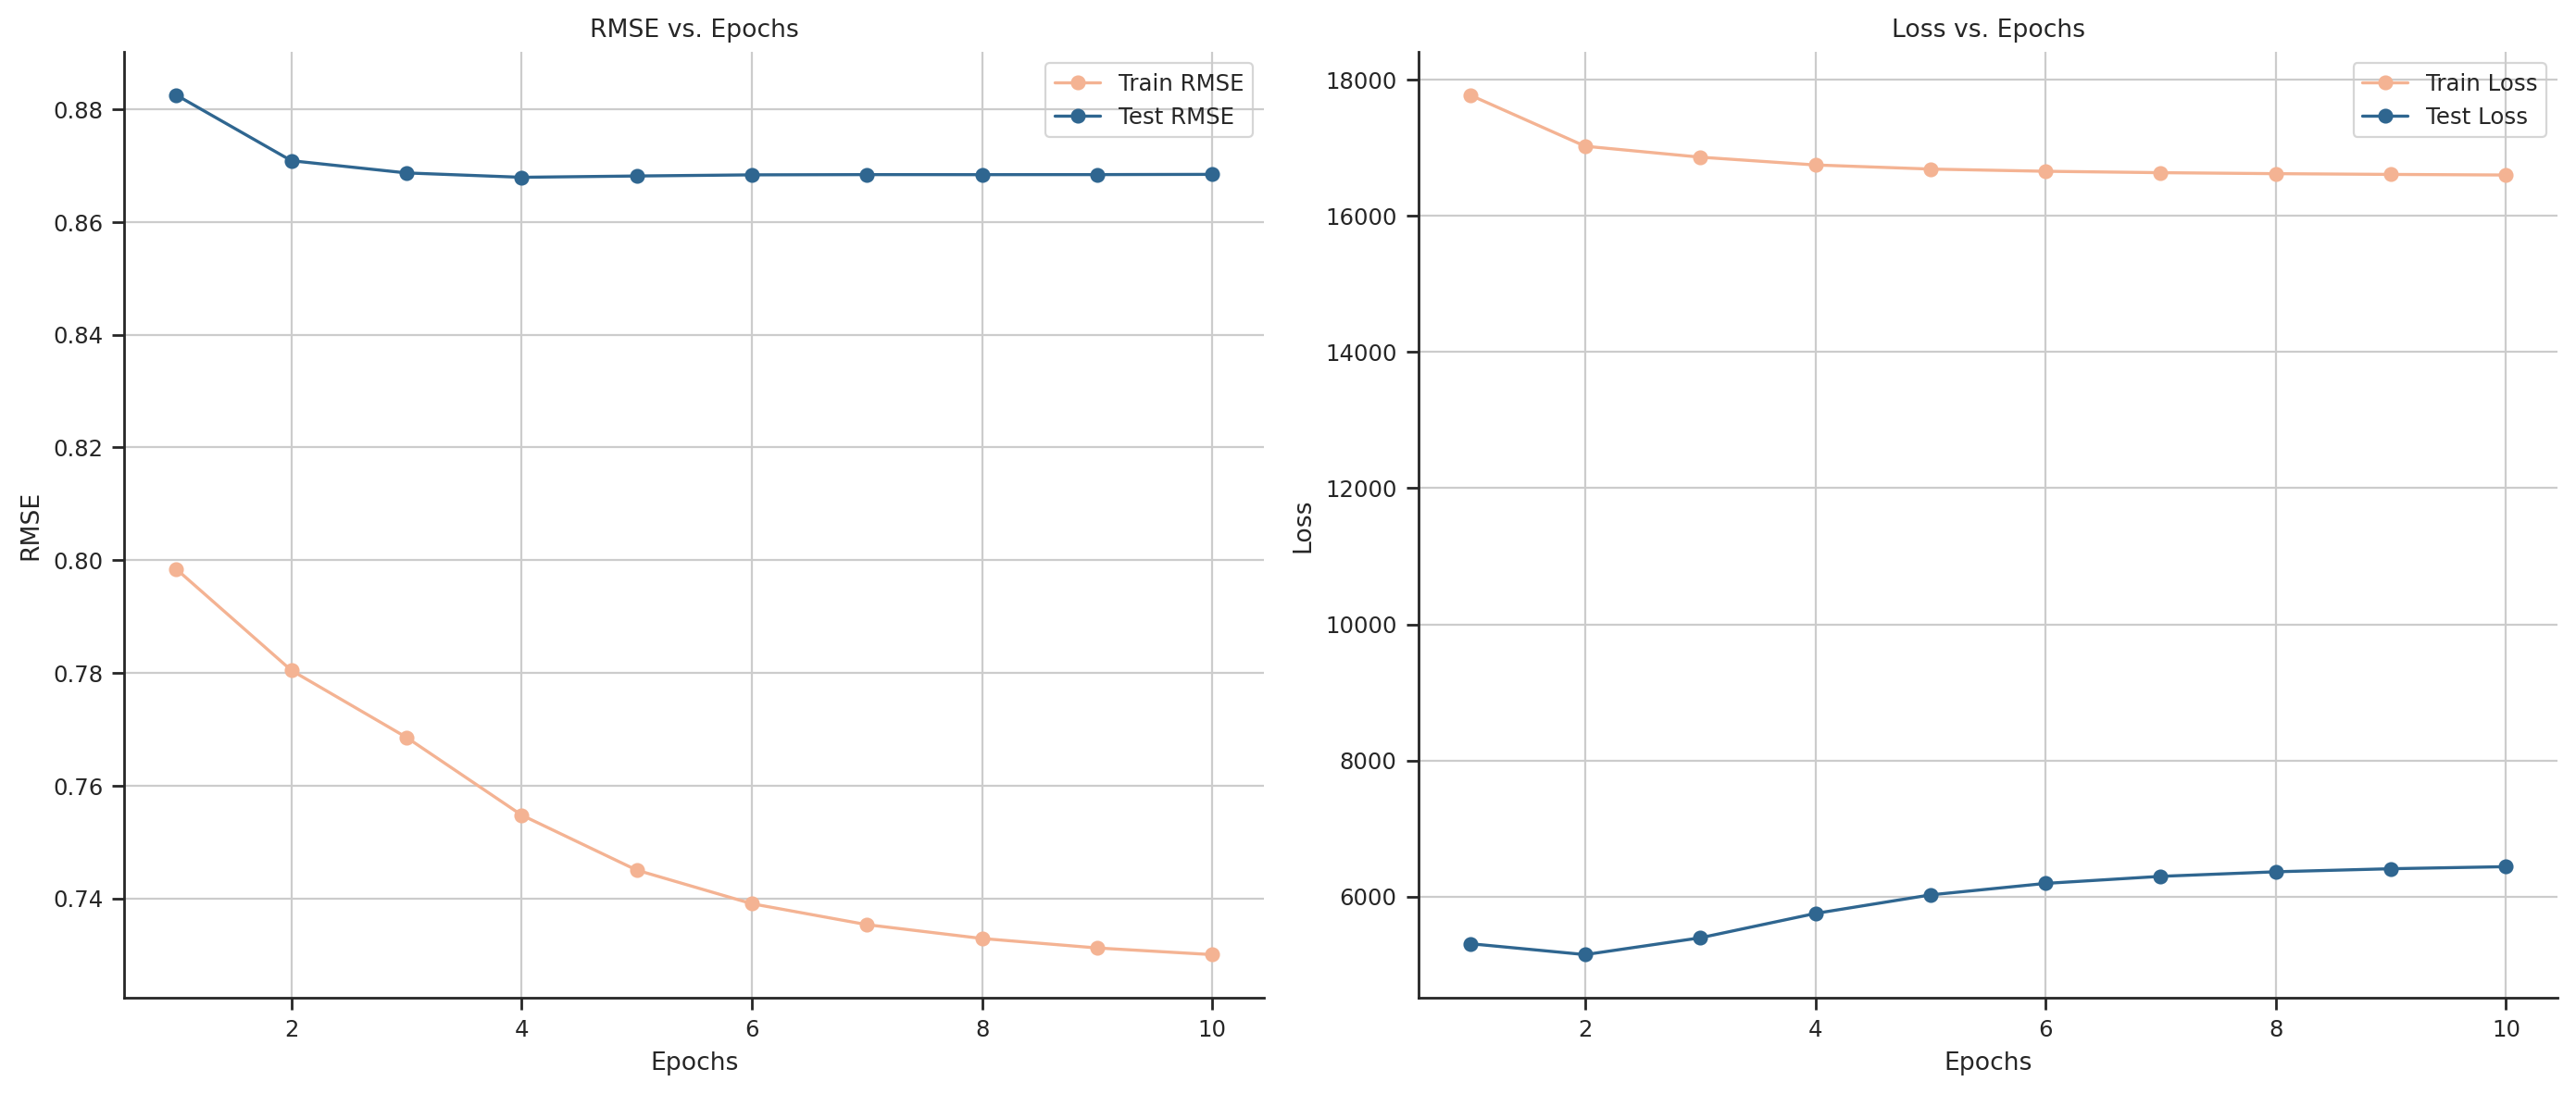

In [ ]:
plot_metrics()

### embeddings plots

In [ ]:
import matplotlib.pyplot as plt
import os

def plot_movie_embeddings_2d(M,
                             movie_bias,
                             k,
                             movie_id_map,
                             sample_size=150,
                             title="2D Movie Embeddings"):
    """
    Plots the 2D movie embeddings from a trained ALS model.

    Args:
        M (np.array): The movie-factor matrix (n_movies, k).
        movie_bias (np.array): The movie bias vector (n_movies,).
        k (int): The number of latent factors (must be 2).
        movie_id_map (dict): The 'inv_movie_dict' mapping index (int) to movie_id (str).
        sample_size (int): Number of movie titles to label on the plot.
        title (str): The title for the plot.
        save_path (str, optional): Full file path (e.g., '.../my_plot.png') to save the figure.
    """
    # 1. Check if model is 2D
    if k != 2:
        print(f"Error: Model's latent factors (k) must be 2 to plot in 2D. This model has k={k}.")
        return

    # 2. Get the embedding matrix and biases
    movie_embeddings = M
    movie_biases = movie_bias

    # 3. Get the two dimensions
    x = movie_embeddings[:, 0]
    y = movie_embeddings[:, 1]

    # 4. Create the scatter plot
    print("Generating embedding plot...")
    fig = plt.figure(figsize=(15, 12))

    # Plot all movies as points, colored by their bias
    sc = plt.scatter(x, y, s=20, c=movie_biases, cmap='coolwarm', alpha=0.6)
    plt.colorbar(sc, label='Movie Bias (Negative/Positive)')

    # 5. Add text labels for a random sample
    n_movies = movie_embeddings.shape[0]

    if sample_size > n_movies:
        sample_size = n_movies # Can't sample more than we have

    # Get random indices to label
    #here to edit for specific titles
    indices_to_label = np.random.choice(n_movies, sample_size, replace=False)

    for idx in indices_to_label:
        # Get the original movie ID from the map
        movie_id = movie_id_map.get(idx, str(idx))

        # Add the text label to the plot (uncommented from your original)
        #plt.text(x[idx], y[idx], f"  {movie_id}", fontsize=9, alpha=0.8)

    # 6. Set plot labels
    # plt.title(title)
    plt.xlabel("Latent Factor 1")
    plt.ylabel("Latent Factor 2")
    plt.grid(True)

    save_path='/content/drive/MyDrive/Colab Notebooks/aai/plots/movie_embeddings_32m_2-10up.pdf'

    # 7. Save the figure if a path is provided
    if save_path:
      fig.savefig(save_path, dpi=500,format='pdf')
        # try:
        #     # Create the directory if it doesn't exist
        #     save_directory = os.path.dirname(save_path)
        #     if save_directory:
        #         os.makedirs(save_directory, exist_ok=True)

        #     # Save the figure

        #     print(f"Embedding plot successfully saved to: {save_path}")
        # except Exception as e:
        #     print(f"ERROR: Could not save embedding plot. {e}")

    # 8. Show the plot
    plt.show()


Plotting movie embeddings...
Generating embedding plot...


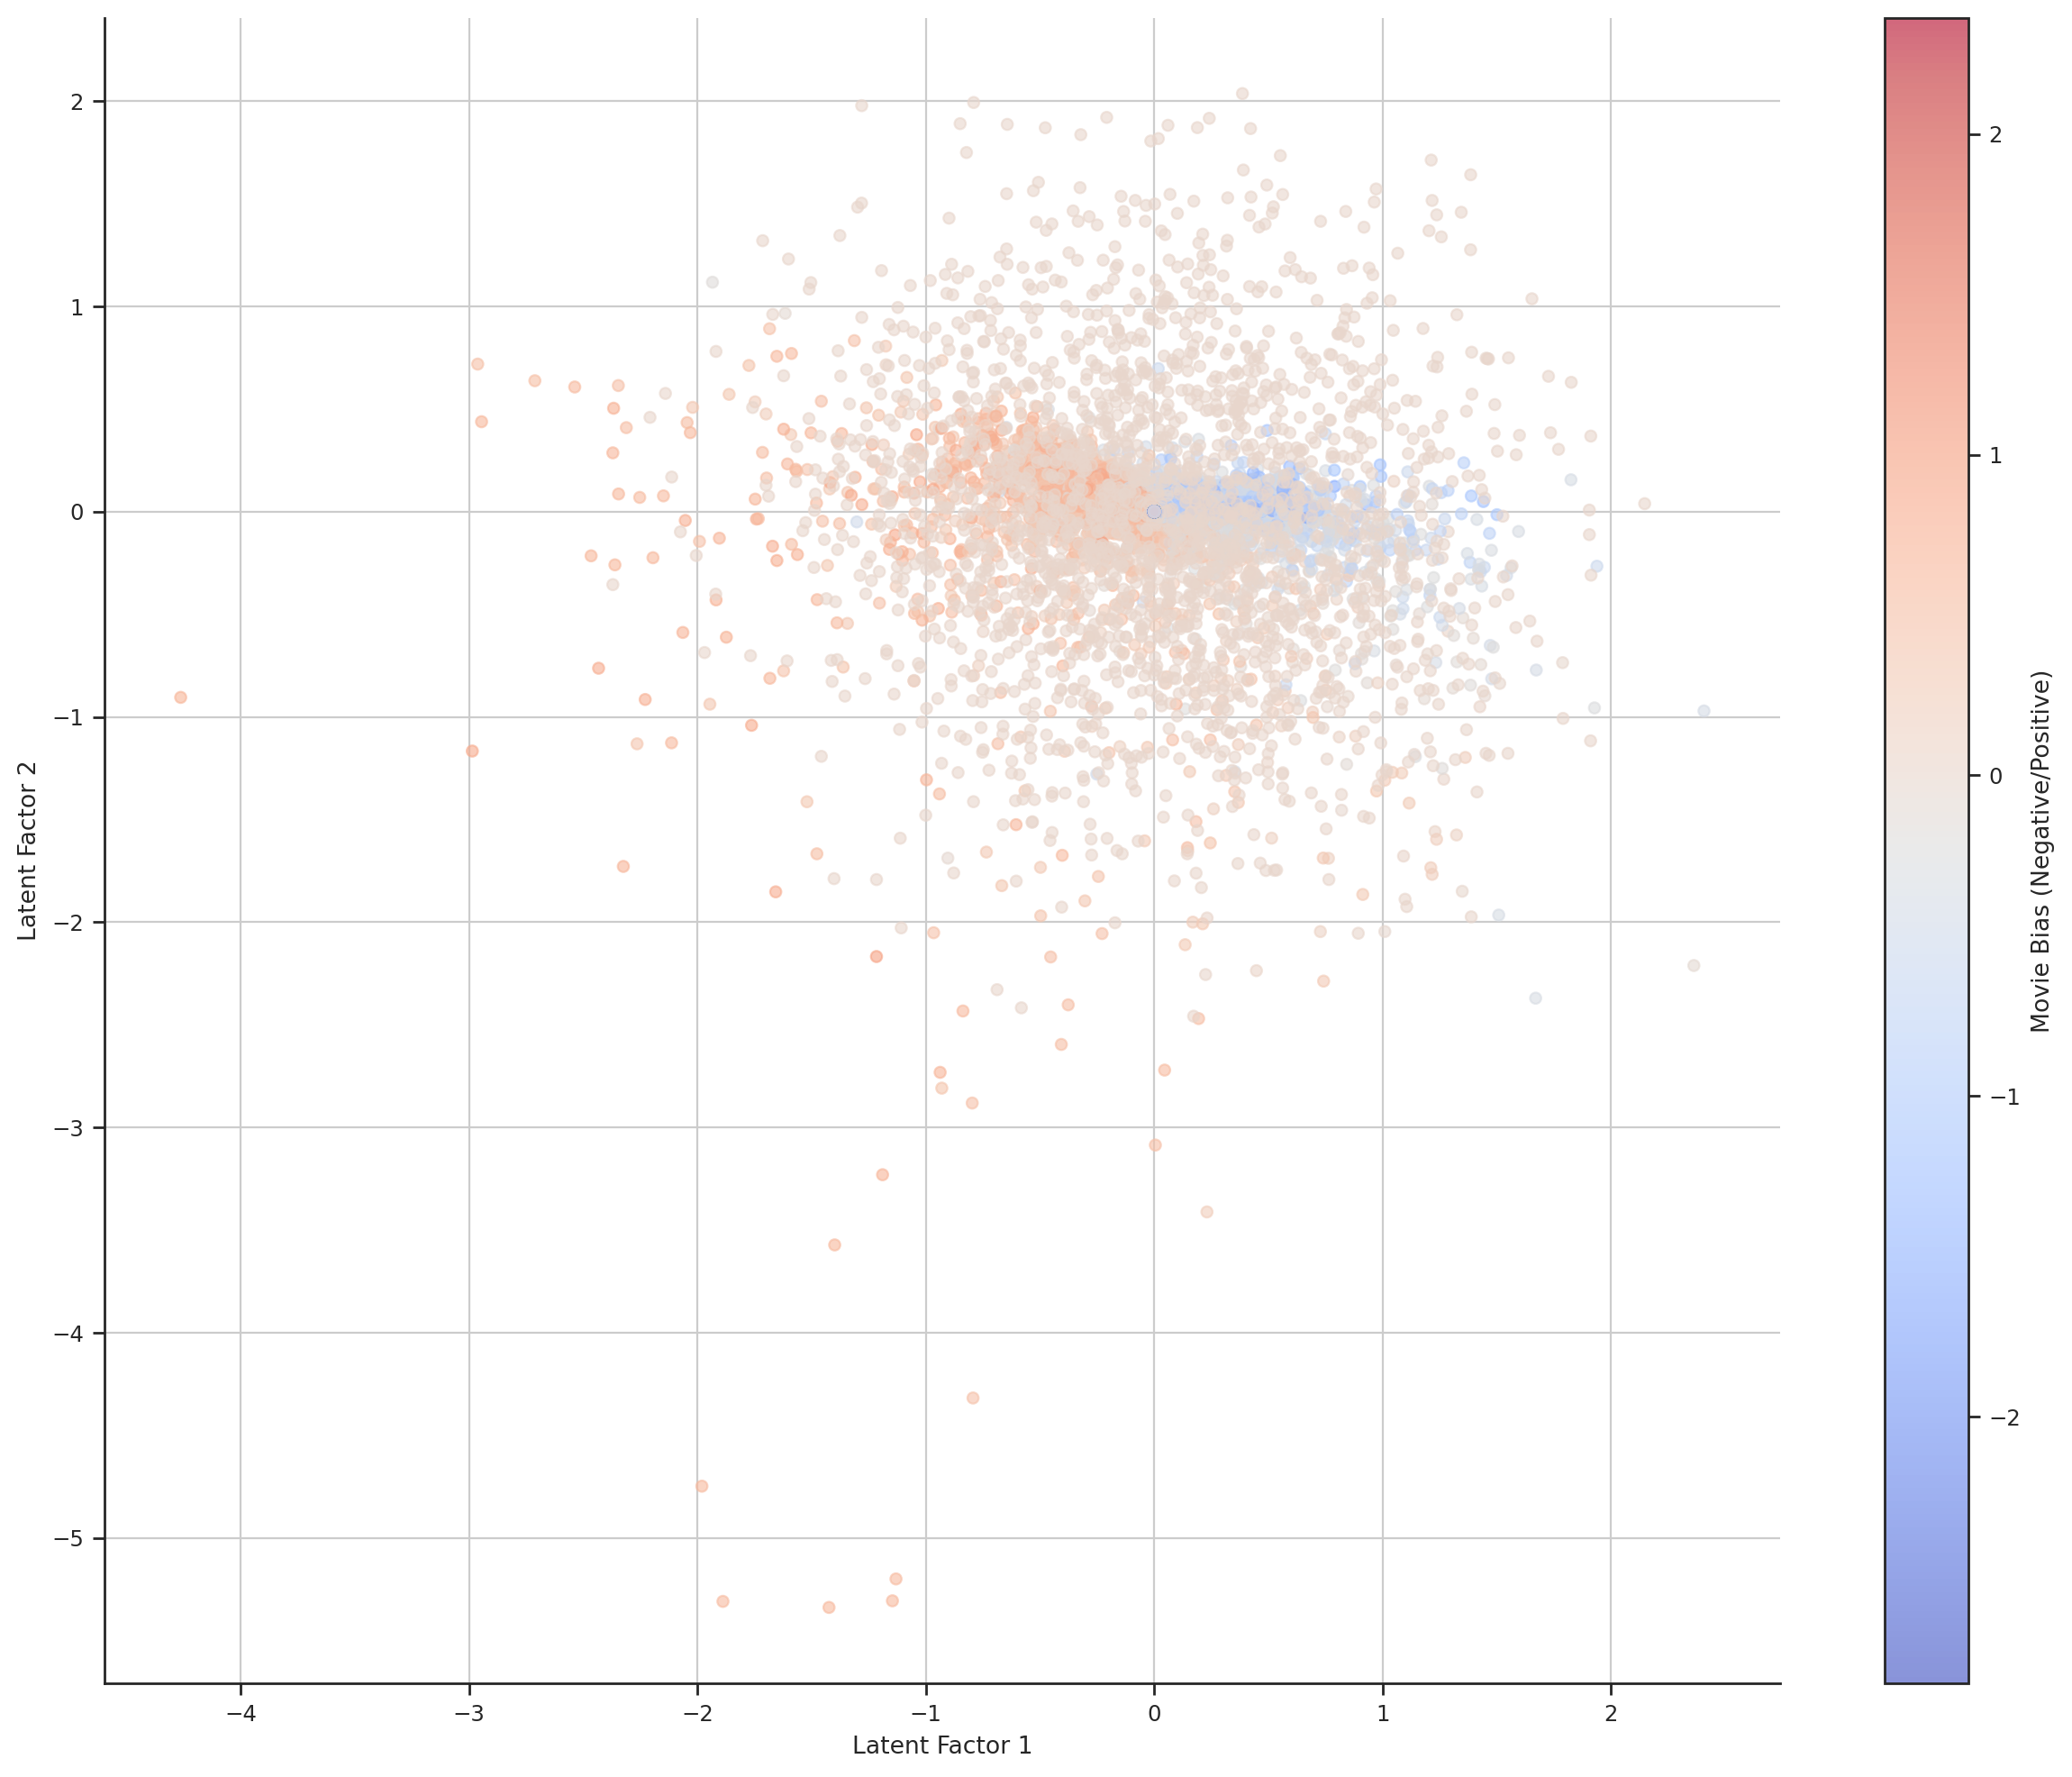

In [ ]:
if k == 2:
    print("\nPlotting movie embeddings...")
    plot_movie_embeddings_2d(
        M=M,                           # Pass the final M matrix
        movie_bias=movie_bias,         # Pass the final movie_bias vector
        k=k,                           # Pass k (which must be 2)
        movie_id_map=inv_movie_dict,   # Pass the inverse map you created
        sample_size=200,
        title=f"Movie Embeddings (k={k}) after {n_epochs} Epochs"
    )
else:
    print(f"\nSkipping 2D embedding plot because k is {k} (must be 2).")

#### embeddigs with titles

In [ ]:

def plot_enhanced_embeddings(M,
                             movie_bias,
                             movie_titles, # Passed from your loading snippet
                             genres_data,  # Passed from your loading snippet
                             highlight_titles=None, # List of specific titles to find
                             highlight_genres=None, # List of specific genres to average
                             save_path=None):
    """
    Plots 2D embeddings with options to highlight specific movies and genre centers.
    """

    # 1. Check dimensions
    k = M.shape[1]
    if k != 2:
        print(f"Error: Model's latent factors (k) must be 2. Current k={k}.")
        return

    # 2. Setup data
    x = M[:, 0]
    y = M[:, 1]

    # Create a quick lookup dictionary for titles {Title: Index}
    # This makes finding specific movies much faster
    title_to_idx = {title: i for i, title in enumerate(movie_titles) if title}

    print("Generating enhanced embedding plot...")
    fig, ax = plt.subplots(figsize=(15, 12))

    # 3. Base Layer: Plot ALL movies (faded background)
    # We reduce alpha (transparency) so the highlights stand out
    sc = ax.scatter(x, y, s=15, c=movie_bias, cmap='coolwarm', alpha=0.3)
    plt.colorbar(sc, label='Movie Bias (Negative/Positive)')

    # --- OPTION 1: Genre Centroids ---
    if highlight_genres:
        print(f"Calculating centroids for genres: {highlight_genres}")
        colors = ['gold', 'lime', 'magenta', 'cyan', 'orange'] # Cycle through these

        for i, target_genre in enumerate(highlight_genres):
            # Find indices of all movies belonging to this genre
            # Note: genres_data is a list of lists, e.g., [['Action'], ['Comedy', 'Romance']]
            genre_indices = [idx for idx, g_list in enumerate(genres_data) if target_genre in g_list]

            if genre_indices:
                # Get coordinates for these movies
                genre_x = x[genre_indices]
                genre_y = y[genre_indices]

                # Calculate Centroid (Mean location)
                center_x = np.mean(genre_x)
                center_y = np.mean(genre_y)

                # Plot the center
                c = colors[i % len(colors)]
                ax.scatter(center_x, center_y, s=300, c=c, edgecolors='black', marker='*', label=f"{target_genre} Avg", zorder=10)
                ax.text(center_x, center_y + 0.02, target_genre.upper(), fontsize=12, fontweight='bold', color='black', ha='center')

    # --- OPTION 2: Highlight Specific Movies ---
    if highlight_titles:
        print(f"Highlighting {len(highlight_titles)} specific movies...")

        for title in highlight_titles:
            idx = title_to_idx.get(title)

            if idx is not None:
                # Plot a distinct point for this movie
                ax.scatter(x[idx], y[idx], s=100, c='black', marker='o', zorder=20)

                # Add text label with a box behind it for readability
                ax.text(x[idx], y[idx], f"  {title}", fontsize=10, fontweight='bold',
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
            else:
                print(f"Warning: Movie '{title}' not found in loaded titles.")

    # 5. Final Formatting
    ax.set_xlabel("Latent Factor 1")
    ax.set_ylabel("Latent Factor 2")
    ax.set_title("Movie Embeddings: Selected Highlights")
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    fig.savefig(save_path, dpi=300, format='pdf')

    # 6. Saving
    # if save_path:
    #     try:
    #         # Create directory if needed
    #         os.makedirs(os.path.dirname(save_path), exist_ok=True)

    #         print(f"Saved to: {save_path}")
    #     except Exception as e:
    #         print(f"Error saving: {e}")

    plt.show()

Generating enhanced embedding plot...
Highlighting 11 specific movies...


/tmp/ipython-input-3425939757.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


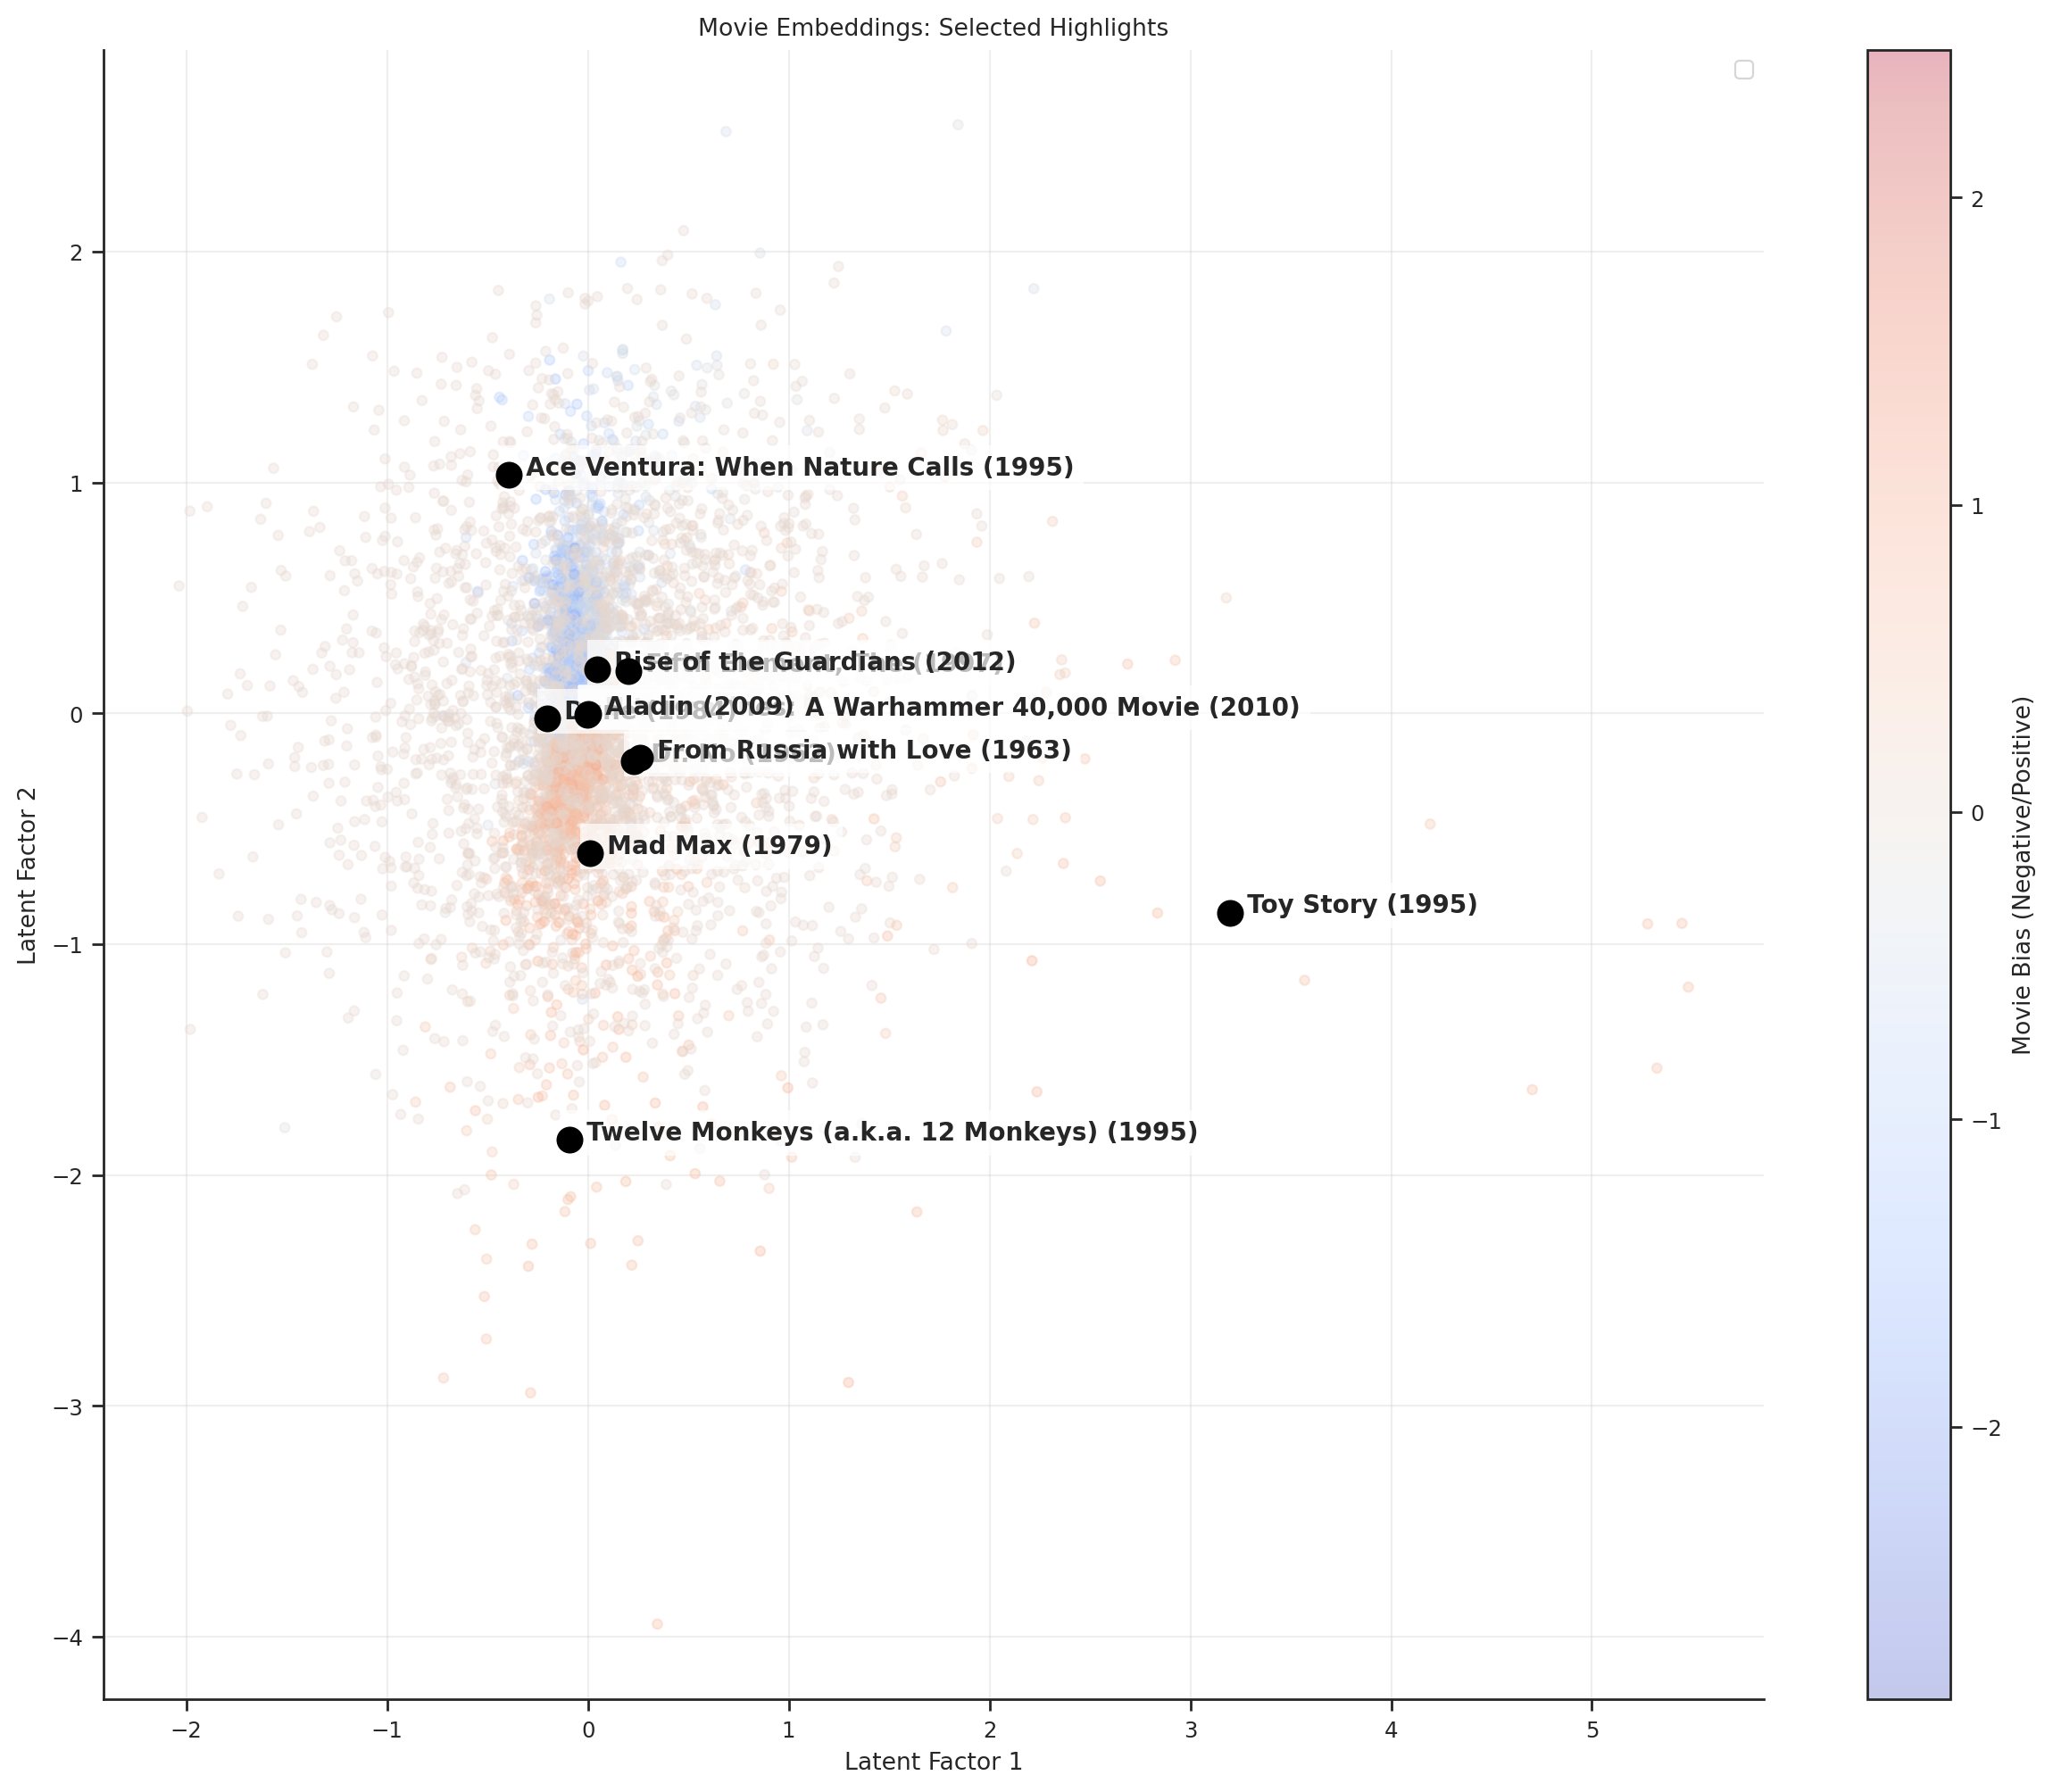

In [ ]:
# Define what you want to see
my_fav_movies = [
    "Toy Story (1995)",
    "Ultramarines: A Warhammer 40,000 Movie (2010)",
    "Dr. No (1962)",
    "Fifth Element, The (1997)",
    "Twelve Monkeys (a.k.a. 12 Monkeys) (1995)",
    "Dune (1984)",
    "Mad Max (1979)",
    "Ace Ventura: When Nature Calls (1995)",
    "From Russia with Love (1963)",
    "Rise of the Guardians (2012)",
    "Aladin (2009)"
]

my_genres_to_map = ["Documentary", "Children","Adventure" ,"Action",
                    "Animation", "Sci-Fi"]

    # highlight_genres=my_genres_to_map,     highlight_titles=my_fav_movies,
# Call the function
plot_enhanced_embeddings(
    M=M,
    movie_bias=movie_bias,
    movie_titles=movie_titles,  # The list you created
    genres_data=genres,         # The list of lists you created
    highlight_titles=my_fav_movies,
    save_path='/content/drive/MyDrive/Colab Notebooks/aai/plots/embed_movies_2.pdf'
)

### converting to numba and optimized training loop

In [ ]:

import numba
from numba import jit, prange
from numba.typed import List as NumbaList


# ----------------------------------------------------------------------
# Numba Pre-processing Function
# ----------------------------------------------------------------------
def build_numba_data(user_index_list, id_to_idx_dict, n_users_or_movies):
    """
    Converts Python list-of-lists data into a Numba-friendly
    CSR-like format (pointers, indices, ratings).
    """
    pointers = NumbaList()
    pointers.append(0)

    indices = NumbaList()
    ratings_data = NumbaList()

    current_idx = 0

    for i in range(n_users_or_movies):
        ratings_list = user_index_list[i]

        for id_str, r in ratings_list:
            idx = id_to_idx_dict.get(str(id_str))
            if idx is not None:
                indices.append(idx)
                ratings_data.append(r)
                current_idx += 1

        pointers.append(current_idx)

    # Convert to NumPy arrays for Numba-JIT functions
    return (
        np.array(pointers, dtype=np.int64),
        np.array(indices, dtype=np.int64),
        np.array(ratings_data, dtype=np.float64)
    )

# ----------------------------------------------------------------------
# Numba-JIT Training Functions
# ----------------------------------------------------------------------

@jit(nopython=True, parallel=True, fastmath=True)
def numba_update_user_biases(pointers, indices, ratings_data,
                             movie_bias, user_bias, # Will be modified in-place
                             lambda_reg, gamma, n_users):
    """Numba-JIT function to update all user biases in parallel."""
    for u in prange(n_users):
        start = pointers[u]
        end = pointers[u+1]

        if end <= start:
            continue

        u_bias_sum = 0.0
        movie_counter = 0
        for i in range(start, end):
            m_idx = indices[i]
            r = ratings_data[i]
            u_bias_sum += (r - (np.dot(U[u],M[m_idx])+movie_bias[m_idx]))
            movie_counter += 1

        if movie_counter > 0:
            user_bias[u] = lambda_reg * u_bias_sum / (lambda_reg * movie_counter + gamma)
        else:
            user_bias[u] = 0.0

@jit(nopython=True, parallel=True, fastmath=True)
def numba_update_user_vectors(pointers, indices, ratings_data,
                              M, U, user_bias, movie_bias, # U is modified
                              k, tau, n_users):
    """Numba-JIT function to update all user vectors in parallel."""
    eye_k = np.eye(k) * tau # Pre-calculate regularization matrix

    for u in prange(n_users):
        start = pointers[u]
        end = pointers[u+1]

        if end <= start:
            continue

        a_u = np.zeros((k, k))
        b_u = np.zeros(k)

        for i in range(start, end):
            m_idx = indices[i]
            r = ratings_data[i]

            v_m = M[m_idx]
            res = r - user_bias[u] - movie_bias[m_idx]

            a_u += np.outer(v_m, v_m)
            b_u += v_m * res

        U[u] = np.linalg.solve(lambda_reg*a_u + eye_k *tau, lambda_reg*b_u)

@jit(nopython=True, parallel=True, fastmath=True)
def numba_update_movie_biases(pointers, indices, ratings_data,
                              user_bias, movie_bias, # Will be modified
                              lambda_reg, gamma, n_movies):
    """Numba-JIT function to update all movie biases in parallel."""
    for m in prange(n_movies):
        start = pointers[m]
        end = pointers[m+1]

        if end <= start:
            continue

        m_bias_sum = 0.0
        user_counter = 0
        for i in range(start, end):
            u_idx = indices[i]
            r = ratings_data[i]
            m_bias_sum += (r - (np.dot(U[u_idx],M[m])+user_bias[u_idx]))
            user_counter += 1

        if user_counter > 0:
            movie_bias[m] = lambda_reg * m_bias_sum / (lambda_reg * user_counter + gamma)
        else:
            movie_bias[m] = 0.0

@jit(nopython=True, parallel=True, fastmath=True)
def numba_update_movie_vectors(pointers, indices, ratings_data,
                               U, M, user_bias, movie_bias, # M is modified
                               k, tau, n_movies):
    """Numba-JIT function to update all movie vectors in parallel."""
    eye_k = np.eye(k) * tau

    for m in prange(n_movies):
        start = pointers[m]
        end = pointers[m+1]

        if end <= start:
            continue

        a_m = np.zeros((k, k))
        b_m = np.zeros(k)

        for i in range(start, end):
            u_idx = indices[i]
            r = ratings_data[i]

            u_m = U[u_idx]
            res = r - user_bias[u_idx] - movie_bias[m]

            a_m += np.outer(u_m, u_m)
            b_m += u_m * res

        M[m] = np.linalg.solve(lambda_reg*a_m + eye_k* tau, lambda_reg*b_m)

# ----------------------------------------------------------------------
# Numba-JIT Metric Function (NEW)
# ----------------------------------------------------------------------

@jit(nopython=True, parallel=True, fastmath=True)
def numba_compute_metrics(pointers, indices, ratings_data,
                          U, M, user_bias, movie_bias, n_users):
    """Calculates total sum-of-squared-errors and count in parallel."""
    # Use private arrays for parallel reduction
    sse_private = np.zeros(numba.get_num_threads())
    count_private = np.zeros(numba.get_num_threads())

    for u in prange(n_users):
        start = pointers[u]
        end = pointers[u+1]

        if end <= start:
            continue

        # Get thread ID for private array access
        tid = numba.get_thread_id()

        for i in range(start, end):
            m_idx = indices[i]
            r = ratings_data[i]

            # Predict
            pred = user_bias[u] + movie_bias[m_idx] + np.dot(U[u], M[m_idx])

            sse_private[tid] += (r - pred) ** 2
            count_private[tid] += 1

    # Sum up the results from all threads
    total_sse = sse_private.sum()
    total_count = count_private.sum()

    return total_sse, total_count

# The trained parameters are now stored in:
# U, M, user_bias, movie_bias
# The metrics are in the ..._history lists

In [ ]:
print("Pre-processing data for Numba...")
# This is for updating user biases and vectors (TRAIN set)
ptr_u, idx_u, dat_u = build_numba_data(user_index_train, movie_dict, n_users)

# This is for updating movie biases and vectors (TRAIN set)
ptr_m, idx_m, dat_m = build_numba_data(movie_index_train, user_dict, n_movies)

# This is for calculating TEST set metrics
ptr_t, idx_t, dat_t = build_numba_data(user_index_test, movie_dict, n_users)

print("Numba data pre-processing complete.")

Pre-processing data for Numba...
Numba data pre-processing complete.


In [ ]:
# ----------------------------------------------------------------------
# Hyperparameters
# ----------------------------------------------------------------------
k = 15          # Number of latent factors
tau = 10     # Regularization for latent vectors (U and M)
lambda_reg = 0.5  # Precision parameter for observed ratings (1/variance)
gamma = 0.2     # Regularization for biases (b_u and b_i)
n_epochs = 12   # Number of epochs to train

# ----------------------------------------------------------------------
# Model Initialization
# ----------------------------------------------------------------------
user_bias = np.zeros(n_users)
movie_bias = np.zeros(n_movies)
U = np.random.normal(0, (1/np.sqrt(k)), (n_users, k))
M = np.random.normal(0, (1/np.sqrt(k)), (n_movies, k))

# History tracking
train_rmse_history = []
test_rmse_history = []
train_loss_history = []
test_loss_history = []


print("Starting ALS model training...")

# --- 1. Pre-process data for Numba ---


# --- 2. Main Training Loop (Now calls JIT functions) ---
# First call to Numba functions will be "slow" as they compile.
# Subsequent epochs will be extremely fast.

print(f"Training model for {n_epochs} epochs...")
for epoch in range(n_epochs):

    # --- 1. Update User Biases ---
    numba_update_user_biases(ptr_u, idx_u, dat_u, movie_bias, user_bias, lambda_reg, gamma, n_users)

    # --- 2. Update User Vectors ---
    numba_update_user_vectors(ptr_u, idx_u, dat_u, M, U, user_bias, movie_bias, k, tau, n_users)

    # --- 3. Update Movie Biases ---
    numba_update_movie_biases(ptr_m, idx_m, dat_m, user_bias, movie_bias, lambda_reg, gamma, n_movies)

    # --- 4. Update Movie Vectors ---
    numba_update_movie_vectors(ptr_m, idx_m, dat_m, U, M, user_bias, movie_bias, k, tau, n_movies)

    # --- 5. Compute and Report Metrics (using Numba) ---
    sse_train, count_train = numba_compute_metrics(ptr_u, idx_u, dat_u, U, M, user_bias, movie_bias, n_users)
    sse_test, count_test = numba_compute_metrics(ptr_t, idx_t, dat_t, U, M, user_bias, movie_bias, n_users)

    # --- RMSE ---
    rmse_train = np.sqrt(sse_train / count_train) if count_train > 0 else 0
    rmse_test = np.sqrt(sse_test / count_test) if count_test > 0 else 0
    train_rmse_history.append(rmse_train)
    test_rmse_history.append(rmse_test)

    # --- COMPLETE LOSS FUNCTION ---
    reg_bias = -0.5 * gamma * (np.sum(user_bias**2) + np.sum(movie_bias**2))
    reg_vectors = -0.5 * tau * (np.sum(U**2) + np.sum(M**2))

    loss_train = -(0.5 * lambda_reg * sse_train) - reg_bias - reg_vectors
    loss_test = -(0.5 * lambda_reg * sse_test) - reg_bias - reg_vectors
    train_loss_history.append(loss_train)
    test_loss_history.append(loss_test)

    print(f"Epoch {epoch+1}/{n_epochs} | Train RMSE: {rmse_train:.5f}, Test RMSE: {rmse_test:.5f} | "
          f"Train Loss: {loss_train:.2f}, Test Loss: {loss_test:.2f}")

print("Training complete.")

Starting ALS model training...
Training model for 12 epochs...
Epoch 1/12 | Train RMSE: 0.85982, Test RMSE: 0.86969 | Train Loss: -5030155.80, Test Loss: -312838.06
Epoch 2/12 | Train RMSE: 0.83823, Test RMSE: 0.84868 | Train Loss: -4771274.03, Test Loss: -288981.87
Epoch 3/12 | Train RMSE: 0.82151, Test RMSE: 0.83477 | Train Loss: -4561781.41, Test Loss: -260554.51
Epoch 4/12 | Train RMSE: 0.81328, Test RMSE: 0.82826 | Train Loss: -4459149.71, Test Loss: -246150.15
Epoch 5/12 | Train RMSE: 0.80925, Test RMSE: 0.82519 | Train Loss: -4409688.95, Test Loss: -239700.09
Epoch 6/12 | Train RMSE: 0.80724, Test RMSE: 0.82371 | Train Loss: -4385727.94, Test Loss: -237192.63
Epoch 7/12 | Train RMSE: 0.80599, Test RMSE: 0.82283 | Train Loss: -4371469.66, Test Loss: -236214.53
Epoch 8/12 | Train RMSE: 0.80513, Test RMSE: 0.82224 | Train Loss: -4362047.93, Test Loss: -235993.88
Epoch 9/12 | Train RMSE: 0.80452, Test RMSE: 0.82184 | Train Loss: -4355758.50, Test Loss: -236257.94
Epoch 10/12 | Train

### hyper params plots

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import numba
# from numba import jit, prange
# from numba.typed import List as NumbaList

# ----------------------------------------------------------------------
# 1. Numba Helper & Training Functions
# ----------------------------------------------------------------------

def build_numba_data(user_index_list, id_to_idx_dict, n_users_or_movies):
    """
    Converts Python list-of-lists data into a Numba-friendly
    CSR-like format (pointers, indices, ratings).
    """
    pointers = NumbaList()
    pointers.append(0)
    indices = NumbaList()
    ratings_data = NumbaList()

    current_idx = 0

    for i in range(n_users_or_movies):
        ratings_list = user_index_list[i]
        for id_str, r in ratings_list:
            idx = id_to_idx_dict.get(str(id_str))
            if idx is not None:
                indices.append(idx)
                ratings_data.append(r)
                current_idx += 1
        pointers.append(current_idx)

    return (
        np.array(pointers, dtype=np.int64),
        np.array(indices, dtype=np.int64),
        np.array(ratings_data, dtype=np.float64)
    )

@jit(nopython=True, parallel=True, fastmath=True)
def numba_update_user_biases(pointers, indices, ratings_data,
                             U, M, movie_bias, user_bias, # Added U, M to args
                             lambda_reg, gamma, n_users):
    """Numba-JIT function to update all user biases in parallel."""
    for u in prange(n_users):
        start = pointers[u]
        end = pointers[u+1]

        if end <= start:
            continue

        u_bias_sum = 0.0
        movie_counter = 0
        for i in range(start, end):
            m_idx = indices[i]
            r = ratings_data[i]
            # Uses passed U and M, not globals
            u_bias_sum += (r - (np.dot(U[u], M[m_idx]) + movie_bias[m_idx]))
            movie_counter += 1

        if movie_counter > 0:
            user_bias[u] = lambda_reg * u_bias_sum / (lambda_reg * movie_counter + gamma)
        else:
            user_bias[u] = 0.0

@jit(nopython=True, parallel=True, fastmath=True)
def numba_update_user_vectors(pointers, indices, ratings_data,
                              M, U, user_bias, movie_bias,
                              k, tau, n_users):
    """Numba-JIT function to update all user vectors in parallel."""
    eye_k = np.eye(k) * tau

    for u in prange(n_users):
        start = pointers[u]
        end = pointers[u+1]

        if end <= start:
            continue

        a_u = np.zeros((k, k))
        b_u = np.zeros(k)

        for i in range(start, end):
            m_idx = indices[i]
            r = ratings_data[i]

            v_m = M[m_idx]
            res = r - user_bias[u] - movie_bias[m_idx]

            a_u += np.outer(v_m, v_m)
            b_u += v_m * res

        U[u] = np.linalg.solve(lambda_reg*a_u + eye_k, lambda_reg*b_u)

@jit(nopython=True, parallel=True, fastmath=True)
def numba_update_movie_biases(pointers, indices, ratings_data,
                              U, M, user_bias, movie_bias, # Added U, M to args
                              lambda_reg, gamma, n_movies):
    """Numba-JIT function to update all movie biases in parallel."""
    for m in prange(n_movies):
        start = pointers[m]
        end = pointers[m+1]

        if end <= start:
            continue

        m_bias_sum = 0.0
        user_counter = 0
        for i in range(start, end):
            u_idx = indices[i]
            r = ratings_data[i]
            # Uses passed U and M
            m_bias_sum += (r - (np.dot(U[u_idx], M[m]) + user_bias[u_idx]))
            user_counter += 1

        if user_counter > 0:
            movie_bias[m] = lambda_reg * m_bias_sum / (lambda_reg * user_counter + gamma)
        else:
            movie_bias[m] = 0.0

@jit(nopython=True, parallel=True, fastmath=True)
def numba_update_movie_vectors(pointers, indices, ratings_data,
                               U, M, user_bias, movie_bias,
                               k, tau, n_movies):
    """Numba-JIT function to update all movie vectors in parallel."""
    eye_k = np.eye(k) * tau

    for m in prange(n_movies):
        start = pointers[m]
        end = pointers[m+1]

        if end <= start:
            continue

        a_m = np.zeros((k, k))
        b_m = np.zeros(k)

        for i in range(start, end):
            u_idx = indices[i]
            r = ratings_data[i]

            u_m = U[u_idx]
            res = r - user_bias[u_idx] - movie_bias[m]

            a_m += np.outer(u_m, u_m)
            b_m += u_m * res

        M[m] = np.linalg.solve(lambda_reg*a_m + eye_k, lambda_reg*b_m)

@jit(nopython=True, parallel=True, fastmath=True)
def numba_compute_metrics(pointers, indices, ratings_data,
                          U, M, user_bias, movie_bias, n_users):
    """Calculates total sum-of-squared-errors and count in parallel."""
    sse_private = np.zeros(numba.get_num_threads())
    count_private = np.zeros(numba.get_num_threads())

    for u in prange(n_users):
        start = pointers[u]
        end = pointers[u+1]
        if end <= start: continue

        tid = numba.get_thread_id()

        for i in range(start, end):
            m_idx = indices[i]
            r = ratings_data[i]
            pred = user_bias[u] + movie_bias[m_idx] + np.dot(U[u], M[m_idx])
            sse_private[tid] += (r - pred) ** 2
            count_private[tid] += 1

    return sse_private.sum(), count_private.sum()


# ----------------------------------------------------------------------
# 2. Hyperparameters & Main Tuning Loop
# ----------------------------------------------------------------------
k_values = [1, 5, 10, 20]
n_epochs = 10
tau = 10
lambda_reg = 0.5
gamma = 0.2

results_store = {}

# Ensure data is ready (Assuming ptr_u, idx_u etc. are in global scope from loading cell)
# If not, you would call build_numba_data() here.

print(f"Starting Hyperparameter Tuning for k = {k_values}...\n")

for k in k_values:
    print(f"--- Training model with k={k} ---")

    # Initialize Local Model for this 'k'
    local_user_bias = np.zeros(n_users)
    local_movie_bias = np.zeros(n_movies)
    local_U = np.random.normal(0, (1/np.sqrt(k)), (n_users, k))
    local_M = np.random.normal(0, (1/np.sqrt(k)), (n_movies, k))

    history = {'train_rmse': [], 'test_rmse': [], 'train_loss': [], 'test_loss': []}

    for epoch in range(n_epochs):
        # 1. Update User Biases (Passing local U/M now)
        numba_update_user_biases(ptr_u, idx_u, dat_u, local_U, local_M, local_movie_bias, local_user_bias, lambda_reg, gamma, n_users)

        # 2. Update User Vectors
        numba_update_user_vectors(ptr_u, idx_u, dat_u, local_M, local_U, local_user_bias, local_movie_bias, k, tau, n_users)

        # 3. Update Movie Biases (Passing local U/M now)
        numba_update_movie_biases(ptr_m, idx_m, dat_m, local_U, local_M, local_user_bias, local_movie_bias, lambda_reg, gamma, n_movies)

        # 4. Update Movie Vectors
        numba_update_movie_vectors(ptr_m, idx_m, dat_m, local_U, local_M, local_user_bias, local_movie_bias, k, tau, n_movies)

        # 5. Metrics
        sse_train, count_train = numba_compute_metrics(ptr_u, idx_u, dat_u, local_U, local_M, local_user_bias, local_movie_bias, n_users)
        sse_test, count_test = numba_compute_metrics(ptr_t, idx_t, dat_t, local_U, local_M, local_user_bias, local_movie_bias, n_users)

        rmse_train = np.sqrt(sse_train / count_train) if count_train > 0 else 0
        rmse_test = np.sqrt(sse_test / count_test) if count_test > 0 else 0

        reg_bias = -0.5 * gamma * (np.sum(local_user_bias**2) + np.sum(local_movie_bias**2))
        reg_vectors = -0.5 * tau * (np.sum(local_U**2) + np.sum(local_M**2))
        loss_train = -(0.5 * lambda_reg * sse_train) - reg_bias - reg_vectors
        loss_test = -(0.5 * lambda_reg * sse_test) - reg_bias - reg_vectors

        history['train_rmse'].append(rmse_train)
        history['test_rmse'].append(rmse_test)
        history['train_loss'].append(loss_train)
        history['test_loss'].append(loss_test)

    results_store[k] = history
    print(f"   Finished k={k}. Final Test RMSE: {history['test_rmse'][-1]:.4f}")



Starting Hyperparameter Tuning for k = [1, 5, 10, 20]...

--- Training model with k=1 ---
   Finished k=1. Final Test RMSE: 0.8263
--- Training model with k=5 ---
   Finished k=5. Final Test RMSE: 0.7938
--- Training model with k=10 ---
   Finished k=10. Final Test RMSE: 0.7764
--- Training model with k=20 ---
   Finished k=20. Final Test RMSE: 0.7692


Generating Mosaic Plot...


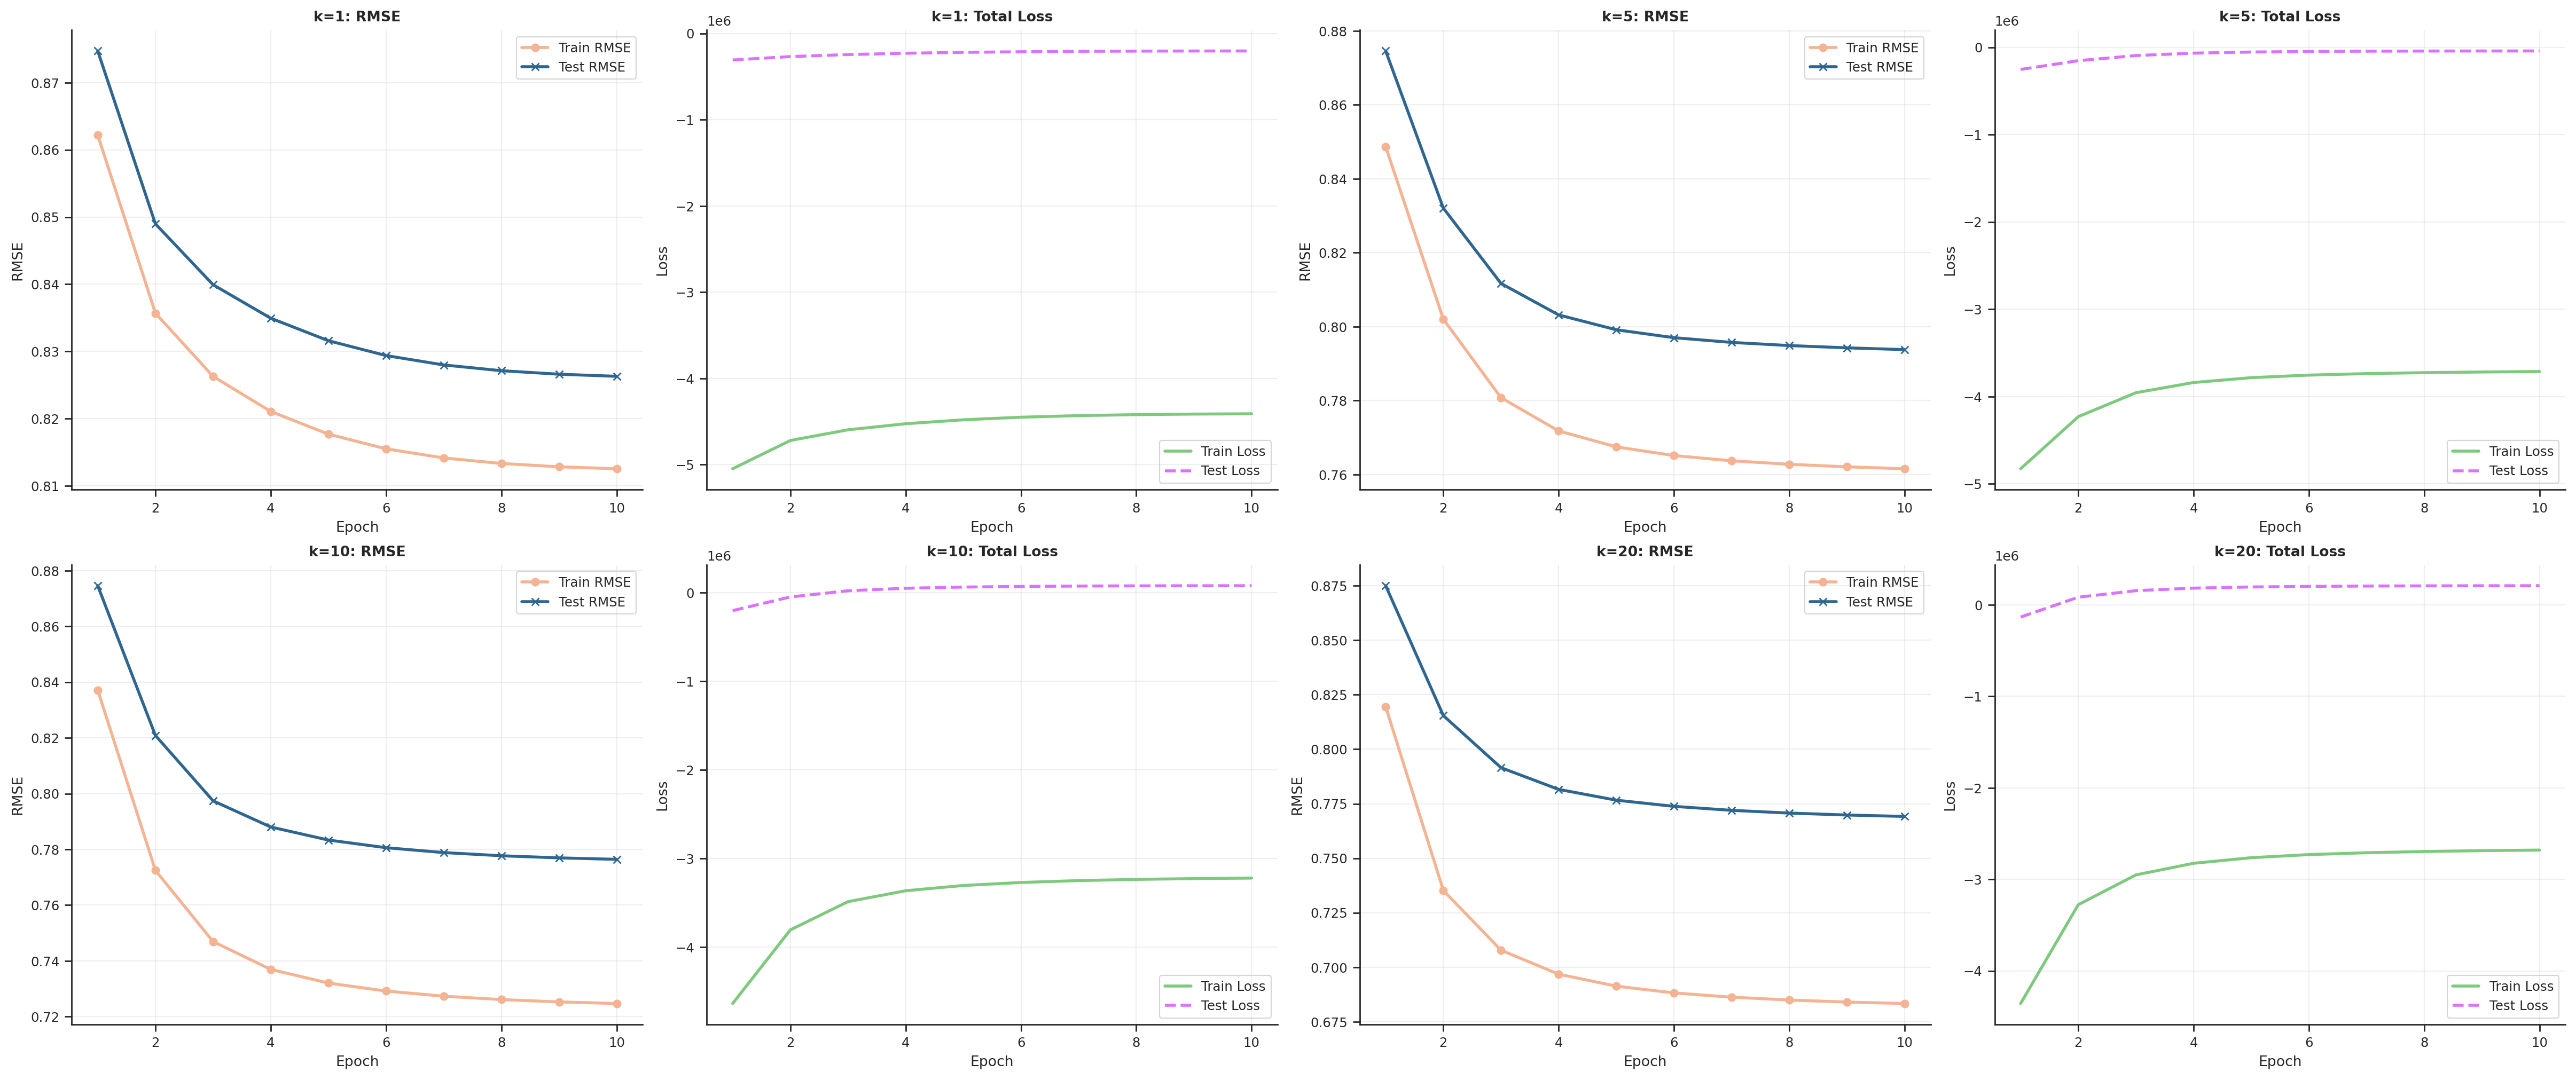

In [ ]:
# ----------------------------------------------------------------------
# 3. Plotting (Subplot Mosaic)
# ----------------------------------------------------------------------
# We define the visual layout using a list of lists containing string keys.
# Row 1: k=1 and k=5
# Row 2: k=10 and k=20
layout = [
    ['rmse_1', 'loss_1', 'rmse_5', 'loss_5'],
    ['rmse_10', 'loss_10', 'rmse_20', 'loss_20']
]

print("Generating Mosaic Plot...")

# constrained_layout=True automatically adjusts spacing and titles
fig, axd = plt.subplot_mosaic(layout, figsize=(24, 10), constrained_layout=True)
# fig.suptitle(f'Hyperparameter Tuning Results (Epochs={n_epochs})', fontsize=20)

for k in k_values:
    data = results_store[k]
    epochs_range = range(1, n_epochs + 1)

    # 1. Plot RMSE
    # We access the specific axes using the keys defined in 'layout'
    ax_rmse = axd[f'rmse_{k}']
    ax_rmse.plot(epochs_range, data['train_rmse'], label='Train RMSE', marker='o', linewidth=2)
    ax_rmse.plot(epochs_range, data['test_rmse'], label='Test RMSE', marker='x', linewidth=2)
    ax_rmse.set_title(f'k={k}: RMSE', fontweight='bold')
    ax_rmse.set_xlabel('Epoch')
    ax_rmse.set_ylabel('RMSE')
    ax_rmse.legend()
    ax_rmse.grid(True, alpha=0.3)

    # 2. Plot Loss
    ax_loss = axd[f'loss_{k}']
    ax_loss.plot(epochs_range, data['train_loss'], label='Train Loss',color=my_pal[2], linewidth=2)
    ax_loss.plot(epochs_range, data['test_loss'], label='Test Loss', color=my_pal[3], linestyle='--', linewidth=2)
    ax_loss.set_title(f'k={k}: Total Loss', fontweight='bold')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()
    ax_loss.grid(True, alpha=0.3)
save_path = '/content/drive/MyDrive/Colab Notebooks/aai/plots/hypertuning.pdf'
fig.savefig(save_path, dpi=500, format='pdf')
plt.show()

## cont

In [ ]:
# ----------------------------------------------------------------------
# Plotting Function
# ----------------------------------------------------------------------
def plot_metrics():
    """
    Plots the training and test RMSE and Loss curves using subplot_mosaic.
    Relies on the global history lists.
    """

    epochs = range(1, len(train_rmse_history) + 1)

    # 1. Define the 1x2 mosaic layout
    mosaic = [["rmse", "loss"]]

    # 2. Create the figure and axes using the mosaic
    fig, axes = plt.subplot_mosaic(
        mosaic,
        figsize=(14, 6)
    )

    # 3. Plot RMSE (Both Train and Test on the 'rmse' axis)
    axes['rmse'].plot(epochs, train_rmse_history, label='Train RMSE')
    axes['rmse'].plot(epochs, test_rmse_history, my_pal[1], label='Test RMSE')
    axes['rmse'].set_title('RMSE vs. Epochs')
    axes['rmse'].set_xlabel('Epochs')
    axes['rmse'].set_ylabel('RMSE')
    axes['rmse'].legend()
    axes['rmse'].grid(True)

    # 4. Plot Loss (Both Train and Test on the 'loss' axis)
    axes['loss'].plot(epochs, train_loss_history, label='Train Loss')
    axes['loss'].plot(epochs, test_loss_history,my_pal[1], label='Test Loss')
    axes['loss'].set_title('Loss vs. Epochs')
    axes['loss'].set_xlabel('Epochs')
    axes['loss'].set_ylabel('Loss')
    axes['loss'].legend()
    axes['loss'].grid(True)

    # 5. Add a figure-level super title
    # (Relies on n_epochs and k being global variables)
    # fig.suptitle(f"Loss and RMSE over {n_epochs} Epochs, k={k}")

    # 6. Use tight_layout to prevent overlap
    plt.tight_layout()

    # 7. Save the 'fig' object directly and add error handling
    #    *** IMPORTANT: Update this path to your desired location ***
    save_path = '/content/drive/MyDrive/Colab Notebooks/aai/plots/23-11-test.pdf'
    fig.savefig(save_path, dpi=500, format='pdf')
    # try:
    #     fig.savefig(save_path, dpi=500, format='svg')
    #     print(f"Plot successfully saved to: {save_path}")
    # except Exception as e:
    #     print(f"ERROR: Could not save plot. {e}")

    # 8. Show the plot last
    plt.show()

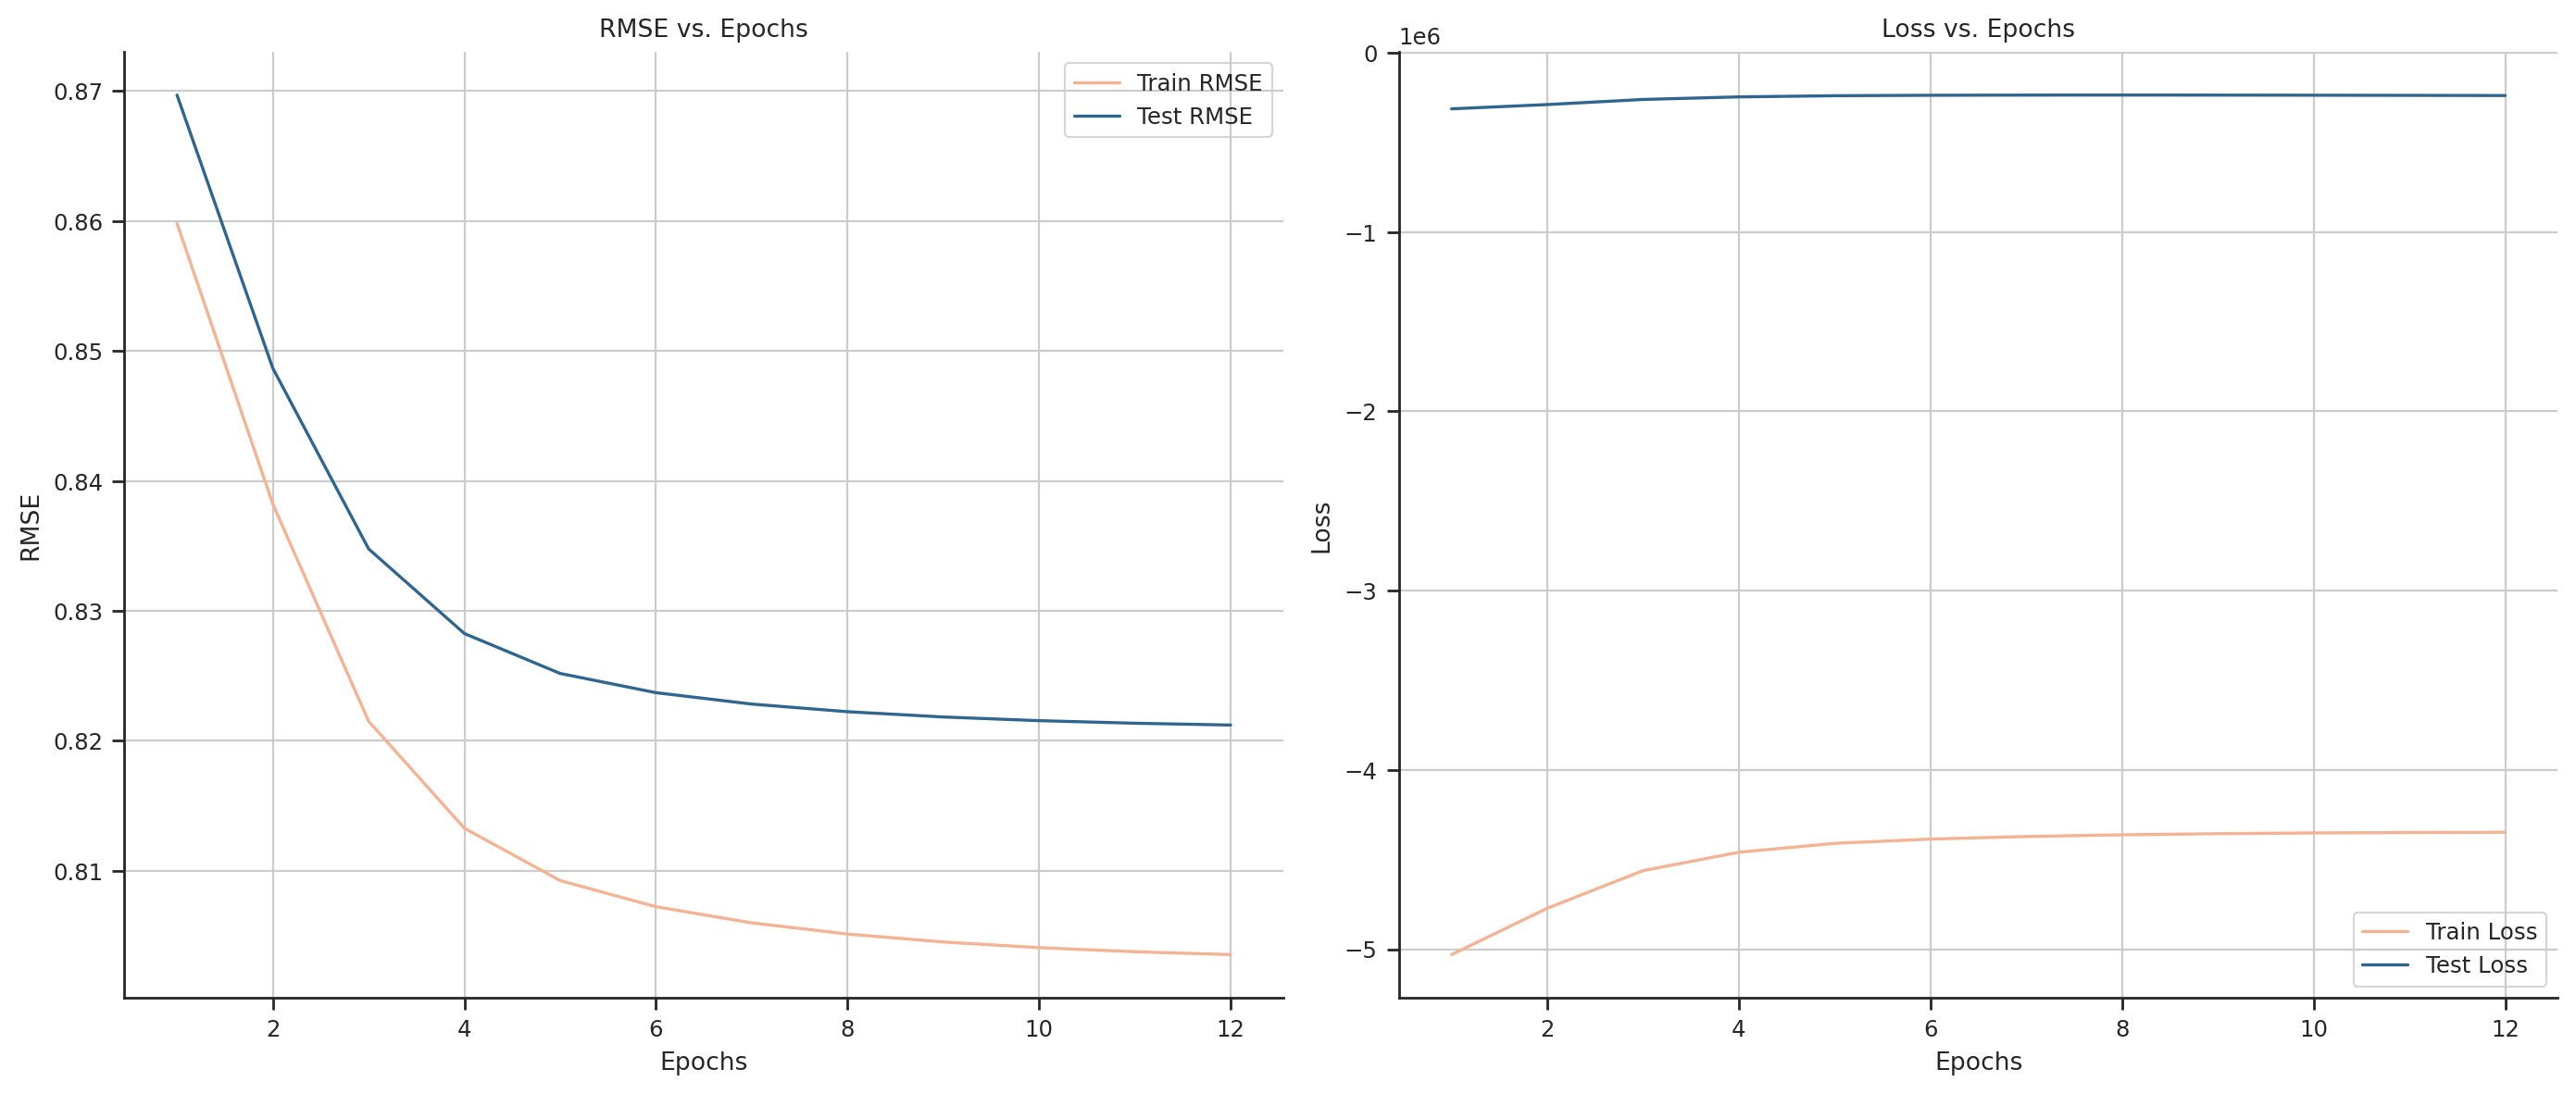

In [ ]:
#remember to add location and enable to save
plot_metrics()

UPDATE LAST


### misc

In [ ]:
import numpy as np
from numba import jit, prange

# ----------------------------------------------------------------------
# 1. Optimized Bias Updates (Vectorized Residual Calculation)
# ----------------------------------------------------------------------

@jit(nopython=True, parallel=True, fastmath=True)
def numba_update_user_biases(pointers, indices, ratings_data,
                             M, U, movie_bias, user_bias,
                             lambda_reg, gamma, n_users):

    for u in prange(n_users):
        start = pointers[u]
        end = pointers[u+1]

        if end <= start:
            continue

        # 1. Slice data for this user
        m_idxs = indices[start:end]
        r_vec = ratings_data[start:end]

        # 2. Get relevant Movie Vectors and Biases
        # shape: (n_ratings, k)
        M_sub = M[m_idxs]
        # shape: (n_ratings,)
        m_bias_sub = movie_bias[m_idxs]

        # 3. Vectorized Prediction: (n_ratings, k) dot (k,) -> (n_ratings,)
        # We perform M_sub @ U[u]
        preds = M_sub.dot(U[u])

        # 4. Vectorized Residual Calculation
        # sum(R - (dot + m_bias))
        residuals = r_vec - (preds + m_bias_sub)
        u_bias_sum = np.sum(residuals)

        count = end - start
        user_bias[u] = lambda_reg * u_bias_sum / (lambda_reg * count + gamma)


@jit(nopython=True, parallel=True, fastmath=True)
def numba_update_movie_biases(pointers, indices, ratings_data,
                              M, U, user_bias, movie_bias,
                              lambda_reg, gamma, n_movies):

    for m in prange(n_movies):
        start = pointers[m]
        end = pointers[m+1]
        if end <= start: continue

        u_idxs = indices[start:end]
        r_vec = ratings_data[start:end]

        U_sub = U[u_idxs]
        u_bias_sub = user_bias[u_idxs]

        # Vectorized Dot Product: U_sub @ M[m]
        preds = U_sub.dot(M[m])

        residuals = r_vec - (preds + u_bias_sub)
        m_bias_sum = np.sum(residuals)

        count = end - start
        movie_bias[m] = lambda_reg * m_bias_sum / (lambda_reg * count + gamma)

# ----------------------------------------------------------------------
# 2. Optimized Vector Updates (Matrix-Matrix Multiplication)
# ----------------------------------------------------------------------

@jit(nopython=True, parallel=True, fastmath=True)
def numba_update_user_vectors(pointers, indices, ratings_data,
                              M, U, user_bias, movie_bias,
                              k, tau, n_users, lambda_reg):

    eye_tau = np.eye(k) * tau

    for u in prange(n_users):
        start = pointers[u]
        end = pointers[u+1]
        if end <= start: continue

        # --- The "Block" Approach ---

        # 1. Identify the movies this user rated
        m_idxs = indices[start:end]

        # 2. Create the "Subset Matrix" M_sub
        # Shape: (n_ratings_for_user, k)
        M_sub = M[m_idxs]

        # 3. Compute A = M_sub.T @ M_sub (BLAS GEMM operation)
        # Instead of a loop of outer products, we do one matrix multiplication.
        # Shape: (k, k)
        A = M_sub.T.dot(M_sub)

        # 4. Compute B
        # We need the residuals: (Rating - UserBias - MovieBias)
        # Note: We do NOT subtract the dot product here, because we are solving for U
        r_vec = ratings_data[start:end]
        m_b_vec = movie_bias[m_idxs]

        # Shape: (n_ratings,)
        raw_residuals = r_vec - user_bias[u] - m_b_vec

        # b = M_sub.T @ raw_residuals
        # Shape: (k,)
        b = M_sub.T.dot(raw_residuals)

        # 5. Regularization and Solve
        # A_reg = lambda * A + tau * I
        A_reg = (A * lambda_reg) + eye_tau
        b_reg = b * lambda_reg

        U[u] = np.linalg.solve(A_reg, b_reg)


@jit(nopython=True, parallel=True, fastmath=True)
def numba_update_movie_vectors(pointers, indices, ratings_data,
                               U, M, user_bias, movie_bias,
                               k, tau, n_movies, lambda_reg):

    eye_tau = np.eye(k) * tau

    for m in prange(n_movies):
        start = pointers[m]
        end = pointers[m+1]
        if end <= start: continue

        # 1. Subset of Users who rated this movie
        u_idxs = indices[start:end]

        # 2. Subset Matrix U_sub
        # Shape: (n_ratings_for_movie, k)
        U_sub = U[u_idxs]

        # 3. A = U_sub.T @ U_sub
        A = U_sub.T.dot(U_sub)

        # 4. Calculate residuals
        r_vec = ratings_data[start:end]
        u_b_vec = user_bias[u_idxs]

        raw_residuals = r_vec - u_b_vec - movie_bias[m]

        # 5. b = U_sub.T @ residuals
        b = U_sub.T.dot(raw_residuals)

        # 6. Solve
        A_reg = (A * lambda_reg) + eye_tau
        b_reg = b * lambda_reg

        M[m] = np.linalg.solve(A_reg, b_reg)

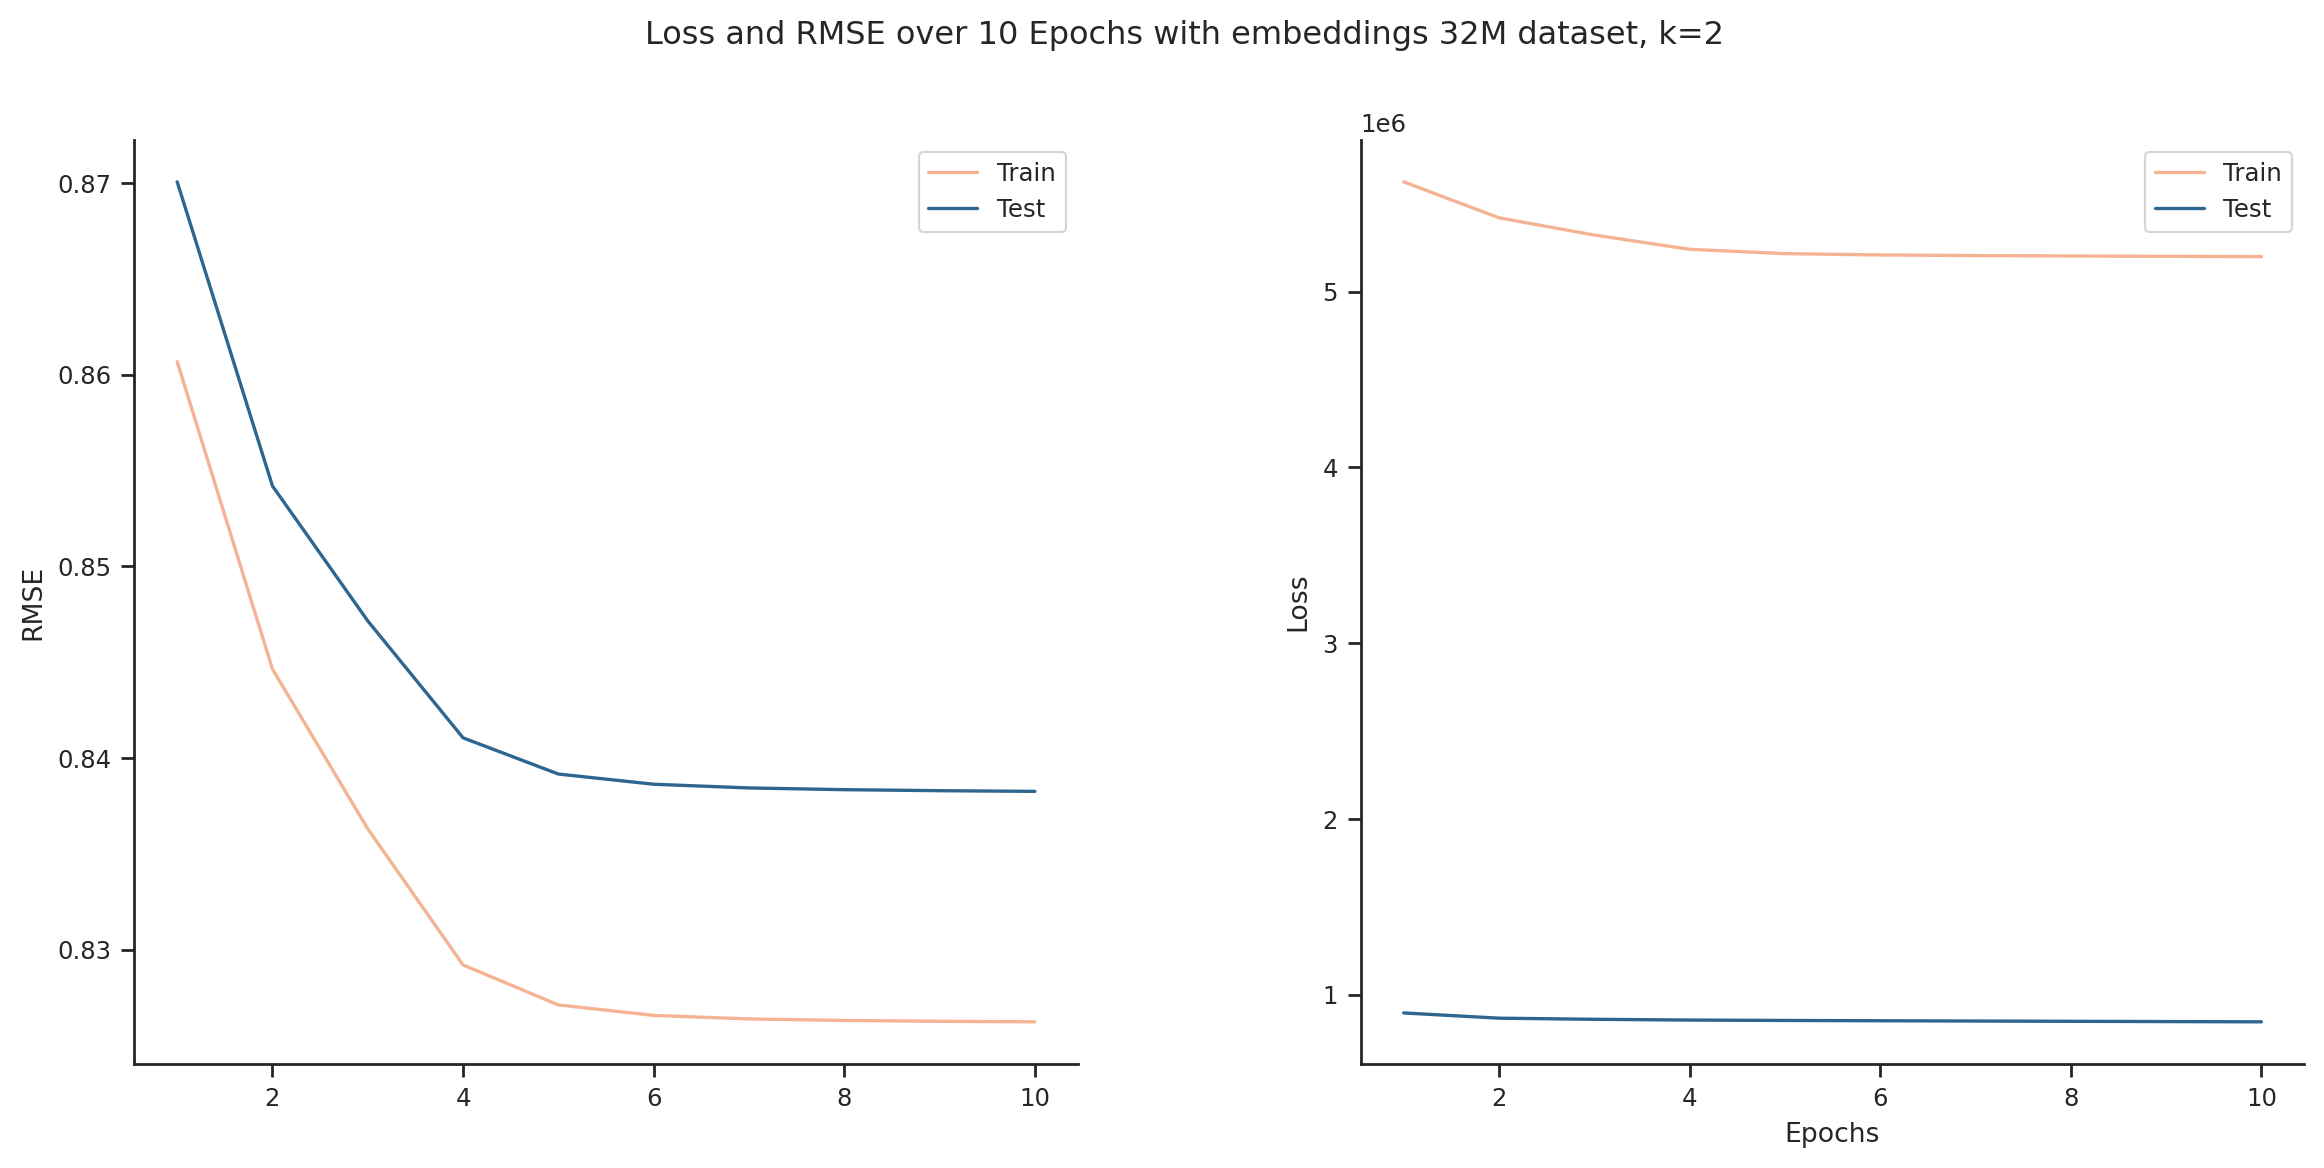

In [ ]:
#plots
fig, axes = plt.subplot_mosaic(
    [
        ["rmse",'loss']
    ],
    gridspec_kw=dict(hspace=0.3,wspace=0.3),
        figsize=(14, 6)
    )
#train_rmse and train_rmse_history
axes['rmse'].plot(np.linspace(1,n_epochs,n_epochs),train_rmse_history,label='Train')
axes['rmse'].plot(np.linspace(1,n_epochs,n_epochs),test_rmse_history,label='Test',color=my_pal[1])
#axes['rmse'].set_ylim(0.5,0.78)
axes['rmse'].set_ylabel('RMSE')
axes['rmse'].legend()
# axes['rmse1'].legend()

axes['loss'].plot(np.linspace(1,n_epochs,n_epochs),train_loss_history,label='Train')
axes['loss'].plot(np.linspace(1,n_epochs,n_epochs),test_loss_history,label='Test',color=my_pal[1])
axes['loss'].legend()
axes['loss'].set_xlabel('Epochs')
axes['loss'].set_ylabel('Loss')
axes['loss'].legend()

# fig.suptitle(f"Loss and RMSE over {n_epochs} Epochs with embeddings 32M dataset, k={k}")

# plt.savefig('/content/drive/MyDrive/Colab Notebooks/aai/plots/loss_rmse_32m_2-10.svg',dpi=500,format='svg')
plt.show()

In [ ]:

save_path = '/content/drive/MyDrive/Colab Notebooks/aai/models/32_m_emb_15_200_num.npz'


np.savez_compressed(
    save_path,
    # --- HYPERPARAMETERS ---
    k=k,              # Number of latent factors
    tau=tau,          # Regularization for latent vectors
    lambda_reg=lambda_reg, # Precision parameter (Corrected typo: was 'l')
    gamma=gamma,        # Regularization for biases
    n_epochs=n_epochs,  # Number of epochs trained

    # --- MODEL ARRAYS ---
    U=U,
    M=M,
    user_bias=user_bias,
    movie_bias=movie_bias
)

print(f"\nModel successfully saved to: {save_path}")


Model successfully saved to: /content/drive/MyDrive/Colab Notebooks/aai/models/32_m_emb_15_200_num.npz


In [ ]:


# Define the path to your saved model
load_path = '/content/drive/MyDrive/Colab Notebooks/aai/models/32_m_emb_17_80_num.npz'

# Load the .npz file
data = np.load(load_path)

# --- Extract Model Arrays ---
U = data['U']
M = data['M']
user_bias = data['user_bias']
movie_bias = data['movie_bias']

# --- Extract Hyperparameters ---
k = data['k'].item()                 # Number of latent factors
tau = data['tau'].item()             # Regularization for latent vectors
lambda_reg = data['lambda_reg'].item() # Precision parameter
gamma = data['gamma'].item()         # Regularization for biases
n_epochs = data['n_epochs'].item()   # Number of epochs trained

print("✅ Model and Hyperparameters loaded successfully!")
print("------------------------------------------------")
print(f"User matrix shape: {U.shape}")
print(f"Movie matrix shape: {M.shape}")
print(f"Hyperparameters loaded:")
print(f"  k (Factors): {k}")
print(f"  tau (Vector Reg): {tau}")
print(f"  Lambda (Precision): {lambda_reg}")

Model loaded successfully!
User matrix shape: (200948, 17)
Movie matrix shape: (84432, 17)


## dummy user testing

In [ ]:
# ----------------------------------------------------------------------
# NEW: Function for Adding a New User (Cold-Start)
# ----------------------------------------------------------------------

def train_new_user(new_user_ratings, n_mini_epochs, movie_dict):
    """
    Adds a new user to the model and trains their bias and vector.

    This function modifies the global 'n_users', 'U', and 'user_bias' arrays.
    It uses the pre-trained 'M' and 'movie_bias' as fixed values.

    Args:
        new_user_ratings (list): A list of (movie_id, rating) tuples.
        n_mini_epochs (int): Number of times to alternate bias/vector updates.
        movie_dict (dict): The global movie_id -> movie_idx mapping.
⅔
    Returns:
        int: The new_user_idx for the added user.
    """
    # These global variables will be modified
    global n_users, U, user_bias

    # 1. Get the new user's index and add them to the global arrays
    new_user_idx = n_users

    # Add a new zero bias
    user_bias = np.append(user_bias, 0.0)

    # Add a new random vector
    new_u_vec = np.random.normal(0, (1/np.sqrt(k)), (1, k))
    U = np.vstack([U, new_u_vec])

    # Increment the global user count
    n_users += 1

    print(f"Adding new user with index: {new_user_idx}. Total users now: {n_users}")

    # 2. Pre-process ratings to get valid movie indices (to speed up the loop)
    new_user_ratings_with_idx = []
    for m_id, r in new_user_ratings:
        m_idx = movie_dict.get(str(m_id))
        if m_idx is not None:
            new_user_ratings_with_idx.append((m_idx, r))

    n_ratings = len(new_user_ratings_with_idx)
    if n_ratings == 0:
        print(f"Warning: New user {new_user_idx} has no valid ratings for known movies.")
        return new_user_idx

    # 3. Train the new user's parameters (bias and vector)
    # We iterate for 'n_mini_epochs'

    # Pre-calculate the fixed parts for the vector update
    # Note: This is where you would add lambda_reg if you changed the formula
    eye_k_reg = np.eye(k) * tau

    for epoch in range(n_mini_epochs):

        # --- Update Bias ---
        # (Based on fixed movie_bias)
        u_bias_sum = 0.0
        for m_idx, r in new_user_ratings_with_idx:
            u_bias_sum += (r - movie_bias[m_idx])

        user_bias[new_user_idx] = (lambda_reg * u_bias_sum) / (lambda_reg * n_ratings + gamma)

        # --- Update Vector ---
        # (Based on fixed M and movie_bias, and the new user_bias)
        a_u = np.zeros((k, k))
        b_u = np.zeros(k)

        for m_idx, r in new_user_ratings_with_idx:
            v_m = M[m_idx] # M is FIXED

            # Use the newly calculated bias for this user
            res = r - user_bias[new_user_idx] - movie_bias[m_idx]

            # This is the (lambda * v_n * v_n^T) part
            # and (lambda * v_n * res) part
            # If you added lambda, add it to both a_u and b_u:
            # a_u += lambda_reg * np.outer(v_m, v_m)
            # b_u += lambda_reg * v_m * res

            # Based on the original simplified formula:
            a_u += np.outer(v_m, v_m)
            b_u += v_m * res

        # Solve for the new user's vector
        U[new_user_idx] = np.linalg.solve(lambda_reg*a_u + tau*eye_k_reg, lambda_reg*b_u)

    print(f"New user {new_user_idx} trained for {n_mini_epochs} epochs.")

    # The embeddings are now stored in U[new_user_idx] and user_bias[new_user_idx]
    return new_user_idx

# ----------------------------------------------------------------------
# Recommendation Functions (Filtered & Scaled)
# ----------------------------------------------------------------------

@jit(nopython=True, fastmath=True)
def numba_predict_all_scores_scaled(user_idx, U, M, user_bias, movie_bias, n_movies, bias_scale):
    """
    Calculates scores for ALL movies with scaled item bias.
    Formula: Score = (M @ u) + u_bias + (movie_bias * scale)
    """
    u_vec = U[user_idx]
    u_bias = user_bias[user_idx]

    # 1. The personalized match (Dot Product)
    # Shape: [n_movies]
    dot_products = M @ u_vec

    # 2. The biased score
    # We multiply movie_bias by bias_scale (e.g., 0.05) to dampen popularity
    scores = dot_products + u_bias + (movie_bias * bias_scale)

    return scores

def recommend_for_user(user_idx,
                       user_rated_movies,
                       movie_dict,
                       movie_index_train,
                       movie_titles,
                       genres_list,  # <--- NEW ARGUMENT
                       top_n=10,
                       min_reviews=20,
                       bias_scale=0.05):
    """
    Generates recommendations including GENRES.
    """
    # 1. Get set of already rated indices
    rated_indices = set()
    for m_id, r in user_rated_movies:
        m_idx = movie_dict.get(str(m_id))
        if m_idx is not None:
            rated_indices.add(m_idx)

    # 2. Calculate SCALED scores for ALL movies
    # (numba function remains the same)
    all_scores = numba_predict_all_scores_scaled(
        user_idx, U, M, user_bias, movie_bias, n_movies, bias_scale
    )

    # 3. Filter, Map, and Moderate
    idx_to_id = {v: k for k, v in movie_dict.items()}
    candidates = []
    banned_movies_found = []

    for m_idx, score in enumerate(all_scores):

        m_id = idx_to_id.get(m_idx)
        if m_id is None: continue

        # Retrieve Title and Genre List
        title = movie_titles[m_idx]
        movie_genres = genres_list[m_idx] # Get the list like ['Action', 'Comedy']

        # --- FILTER 1: MODERATION (HEAVILY WEIGHTED/BANNED) ---
        if m_id in BANNED_MOVIE_IDS:
            # Append tuple: (Score, ID, Title, Genres)
            banned_movies_found.append((score, m_id, title, movie_genres))
            continue

        # Skip if user already saw it
        if m_idx in rated_indices:
            continue

        # --- FILTER 2: POPULARITY CHECK ---
        if len(movie_index_train[m_idx]) < min_reviews:
            continue

        # If passed filters, add to candidates
        candidates.append((score, m_id, title, movie_genres))

    # 4. Sort and Slice
    candidates.sort(key=lambda x: x[0], reverse=True)

    top_recs = candidates[:top_n]
    bottom_recs = candidates[-top_n:]

    return top_recs, bottom_recs, banned_movies_found

In [ ]:
# Banned Movie IDs (Heavily weighted movies to be removed from recommendations)
BANNED_MOVIE_IDS = {
    '171331', '224711', '159817', '171011', '101964', '105250', '239316','171495'
}

# ----------------------------------------------------------------------
# 🎬 Example: Smart Recommendations (Moderated & Named WITH GENRES)
# ----------------------------------------------------------------------

print("\n--- New Dummy User Recommendation Example (Moderated) ---")

# ... (ratings and settings defined here) ...
# Example: User loves "Game of Thrones" (116215)
new_dummy_ratings = [('2949', 5.0)]
new_user_epochs = 5
top_n_recs = 10
MIN_REVIEWS = 100
BIAS_SCALE = 0.05

try:
    # 1. Train the new user
    print(f"Training dummy user for {new_user_epochs} epochs...")
    dummy_user_index = train_new_user(
        new_dummy_ratings,
        new_user_epochs,
        movie_dict
    )

    # --- NEW CODE: Display Rated Films ---
    print("\n--- ⭐️ Dummy User Input Ratings ---")

    rated_films_info = []
    for m_id, rating in new_dummy_ratings:
        m_idx = movie_dict.get(str(m_id)) # Ensure key is string
        if m_idx is not None:
            title = movie_titles[m_idx]
            # Get genre string for the rated movie too
            g_str = ", ".join(genres[m_idx])
            rated_films_info.append(f"Rated: '{title}' [{g_str}] ({rating:.1f}/5.0)")
        else:
            rated_films_info.append(f"Rated: Movie ID {m_id} (Not found) ({rating:.1f}/5.0)")

    for info in rated_films_info:
        print(f"  {info}")
    print("-----------------------------------")


    # 2. Get Recommendations
    # Now passing 'genres' and expecting 4 values in return tuples
    top_recs, bottom_recs, banned_list = recommend_for_user(
        dummy_user_index,
        new_dummy_ratings,
        movie_dict,
        movie_index_train,
        movie_titles,
        genres_list=genres,   # <--- PASS GLOBAL GENRES LIST HERE
        top_n=top_n_recs,
        min_reviews=MIN_REVIEWS,
        bias_scale=BIAS_SCALE
    )

    # 3. Print Results
    # Format: Score | ID | Title | Genres

    print(f"\n--- ✅ Top {top_n_recs} Recommendations (Filtered & Scaled) ---")
    print(f"Criteria: Min {MIN_REVIEWS} reviews | Bias Scale {BIAS_SCALE}")
    print(f"{'Score':<8} | {'ID':<8} | {'Title':<35} | {'Genres'}")
    print("-" * 90)

    if not top_recs:
        print("No recommendations found.")
    else:
        # Loop through (score, ID, title, GENRES)
        for pred_rating, movie_id, title, genre_list in top_recs:
            g_str = ", ".join(genre_list)
            # Truncate title to 35 chars to keep table aligned
            print(f"{pred_rating:.4f}   | {movie_id:<8} | {title[:35]:<35} | {g_str}")

    # 4. Print Bottom 10
    print(f"\n--- ❌ Bottom {top_n_recs} Recommendations ---")
    print(f"{'Score':<8} | {'ID':<8} | {'Title':<35} | {'Genres'}")
    print("-" * 90)

    if not bottom_recs:
        print("No recommendations found.")
    else:
        # Reversed so the absolute worst is at the bottom
        for pred_rating, movie_id, title, genre_list in reversed(bottom_recs):
            g_str = ", ".join(genre_list)
            print(f"{pred_rating:.4f}   | {movie_id:<8} | {title[:35]:<35} | {g_str}")

    # 5. Report Banned Movies Found
    if banned_list:
        print(f"\n--- 🚫 Moderation Report ({len(banned_list)} Banned Candidates Skipped) ---")
        for score, movie_id, title, genre_list in banned_list:
            print(f"  [Skipped] {title:<40} (Score: {score:.2f})")

except Exception as e:
    print(f"\nCould not run new user example.")
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()
    print("Ensure all global lists (movie_dict, movie_index_train, movie_titles, genres) are correctly loaded.")


--- New Dummy User Recommendation Example (Moderated) ---
Training dummy user for 5 epochs...
Adding new user with index: 200953. Total users now: 200954
New user 200953 trained for 5 epochs.

--- ⭐️ Dummy User Input Ratings ---
  Rated: 'Dr. No (1962)' [Action, Adventure, Thriller] (5.0/5.0)
-----------------------------------

--- ✅ Top 10 Recommendations (Filtered & Scaled) ---
Criteria: Min 100 reviews | Bias Scale 0.05
Score    | ID       | Title                               | Genres
------------------------------------------------------------------------------------------
3.4238   | 170705   | Band of Brothers (2001)             | Action, Drama, War
3.4224   | 26073    | Human Condition III, The (Ningen no | Drama, War
3.4217   | 858      | Godfather, The (1972)               | Crime, Drama
3.4198   | 220528   | Twelve Angry Men (1954)             | Drama
3.4195   | 26082    | Harakiri (Seppuku) (1962)           | Drama
3.4191   | 198185   | Twin Peaks (1989)                   

## Old sparse array loading

dicts


vectors for index

In [ ]:
N = 1000
n_data= len(r_ratings)
n_users = int(max(r_users))
n_movies = int(max(r_movies))

NameError: name 'r_ratings' is not defined

In [ ]:
# users index to use the rating
user_index = [[] for _ in range(n_users)]
n=0
for i in range(n_data):
  userid = int(r_users[i])-1
  movieid = int(r_movies[i])
  rating = float(r_ratings[i])
  loc=[i,2]
  user_index[userid].append([movieid,rating])
  #if i == N:
  #  break
  #n+=1


In [ ]:
user_index[0][0]

[17, 4.0]

In [ ]:
len(user_index[0])

141

In [ ]:
user_index = np.load("user_index.npz",allow_pickle = True)["data"]

In [ ]:
user_index

array([list([[17, 4.0], [25, 1.0], [29, 2.0], [30, 5.0], [32, 5.0], [34, 2.0], [36, 1.0], [80, 5.0], [110, 3.0], [111, 5.0], [161, 1.0], [166, 5.0], [176, 4.0], [223, 3.0], [232, 5.0], [260, 5.0], [302, 4.0], [306, 5.0], [307, 5.0], [322, 4.0], [345, 1.0], [356, 2.0], [527, 3.0], [541, 5.0], [562, 5.0], [593, 3.0], [608, 2.0], [645, 4.0], [800, 4.0], [835, 3.0], [838, 5.0], [908, 5.0], [909, 5.0], [912, 2.0], [915, 5.0], [916, 4.0], [923, 5.0], [926, 5.0], [927, 5.0], [933, 5.0], [971, 3.0], [1041, 5.0], [1056, 5.0], [1060, 2.0], [1080, 1.0], [1090, 5.0], [1094, 4.0], [1120, 1.0], [1136, 1.0], [1150, 4.0], [1172, 3.0], [1178, 4.0], [1183, 4.0], [1196, 5.0], [1197, 1.0], [1199, 2.0], [1200, 5.0], [1203, 5.0], [1204, 1.0], [1208, 5.0], [1210, 2.0], [1211, 2.0], [1213, 5.0], [1217, 5.0], [1221, 5.0], [1225, 4.0], [1228, 5.0], [1233, 5.0], [1234, 5.0], [1236, 4.0], [1242, 1.0], [1247, 5.0], [1259, 4.0], [1262, 4.0], [1263, 5.0], [1270, 5.0], [1272, 5.0], [1276, 3.0], [1288, 4.0], [1296, 3.

In [ ]:
user_id_np = np.array(user_index,dtype=object)
np.savez_compressed("user_index_csv.npz",data=user_id_np)
#np.save("user_id10.npy",user_id_np)

Movies index


In [ ]:
movie_index = [[] for movies in range(n_movies)]
nm=0
for j, movies in enumerate(ratings_np):
  userid = int(movies[0])
  movieid = int(movies[1])-1
  rating= float(movies[2])
  #loc=[i,2]
  movie_index[movieid].append([userid,rating])
  #if nm== N:
  #  break
  #nm+=1


In [ ]:
movie_index = np.load("movie_index.npz",allow_pickle=True)["data"]

In [ ]:
len(movie_index[0])

68997

In [ ]:
movie_id_np = np.array(movie_index,dtype=object)
np.savez_compressed("movie_index.npz",data=movie_id_np)
#np.save("movie_id10.npy",movie_id_np)

In [ ]:
movie_index

array([list([[10, 2.5], [11, 3.0], [17, 4.0], [19, 3.0], [20, 5.0], [23, 3.0], [24, 4.0], [28, 4.0], [33, 5.0], [34, 4.0], [36, 3.0], [37, 1.0], [43, 5.0], [46, 4.0], [51, 3.5], [54, 4.0], [57, 4.0], [59, 4.0], [60, 3.0], [62, 5.0], [64, 5.0], [65, 2.0], [67, 4.0], [70, 4.0], [74, 4.5], [76, 4.5], [78, 4.0], [83, 3.0], [84, 4.0], [85, 4.0], [87, 3.5], [88, 4.0], [93, 4.0], [95, 4.5], [100, 5.0], [103, 4.0], [106, 2.5], [107, 3.5], [109, 4.0], [115, 4.0], [117, 3.0], [118, 4.5], [119, 3.5], [120, 5.0], [128, 3.5], [130, 3.0], [131, 4.0], [135, 5.0], [138, 3.0], [139, 4.0], [148, 1.0], [150, 4.0], [157, 4.5], [158, 4.0], [163, 4.0], [165, 3.0], [166, 4.0], [171, 5.0], [173, 4.5], [174, 3.5], [176, 2.5], [182, 3.0], [187, 4.5], [188, 4.0], [199, 5.0], [201, 5.0], [202, 4.0], [203, 3.5], [204, 4.0], [206, 5.0], [208, 3.0], [215, 3.0], [219, 5.0], [220, 4.5], [223, 4.0], [226, 3.0], [228, 4.0], [232, 4.0], [237, 2.5], [238, 4.0], [242, 3.5], [245, 3.0], [249, 5.0], [251, 3.0], [252, 3.5], [

## Plots for eda with pandas

In [ ]:
movies = pd.read_csv(f"{dir}movies.csv")
ratings = pd.read_csv(f"{dir}ratings.csv")
tags= pd.read_csv(f"{dir}tags.csv")
links = pd.read_csv(f"{dir}links.csv")

In [ ]:
ratings.head()

userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858

what is the most rated, watched movie

what are the stats of the most watched movie and how long is it

duration of movies?

highest average rated from a user, and lowest rated

In [ ]:
my_pal = ['F4B393', '2F6690', '7FC97F', 'D972FF', 'CA1551', 'D58C2E', 'C9492C', '000000']
my_pal = [f"#{c}" for c in my_pal]

sns.reset_defaults() # useful when adjusting style a lot
plt.rcParams['font.family']=['sans-serif']
sns.set_theme(context="paper", style="ticks",
              # palette="Set2",
              palette=my_pal,
              rc={
              "pdf.fonttype": 42,  # embed font in output
              "svg.fonttype": "none",  # embed font in output
              "figure.facecolor": "white",
              "figure.dpi": 200,
              "axes.facecolor": "None",
              "axes.spines.left": True,
              "axes.spines.bottom": True,
              "axes.spines.right": False,
              "axes.spines.top": False,
          },
          )

In [ ]:
movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

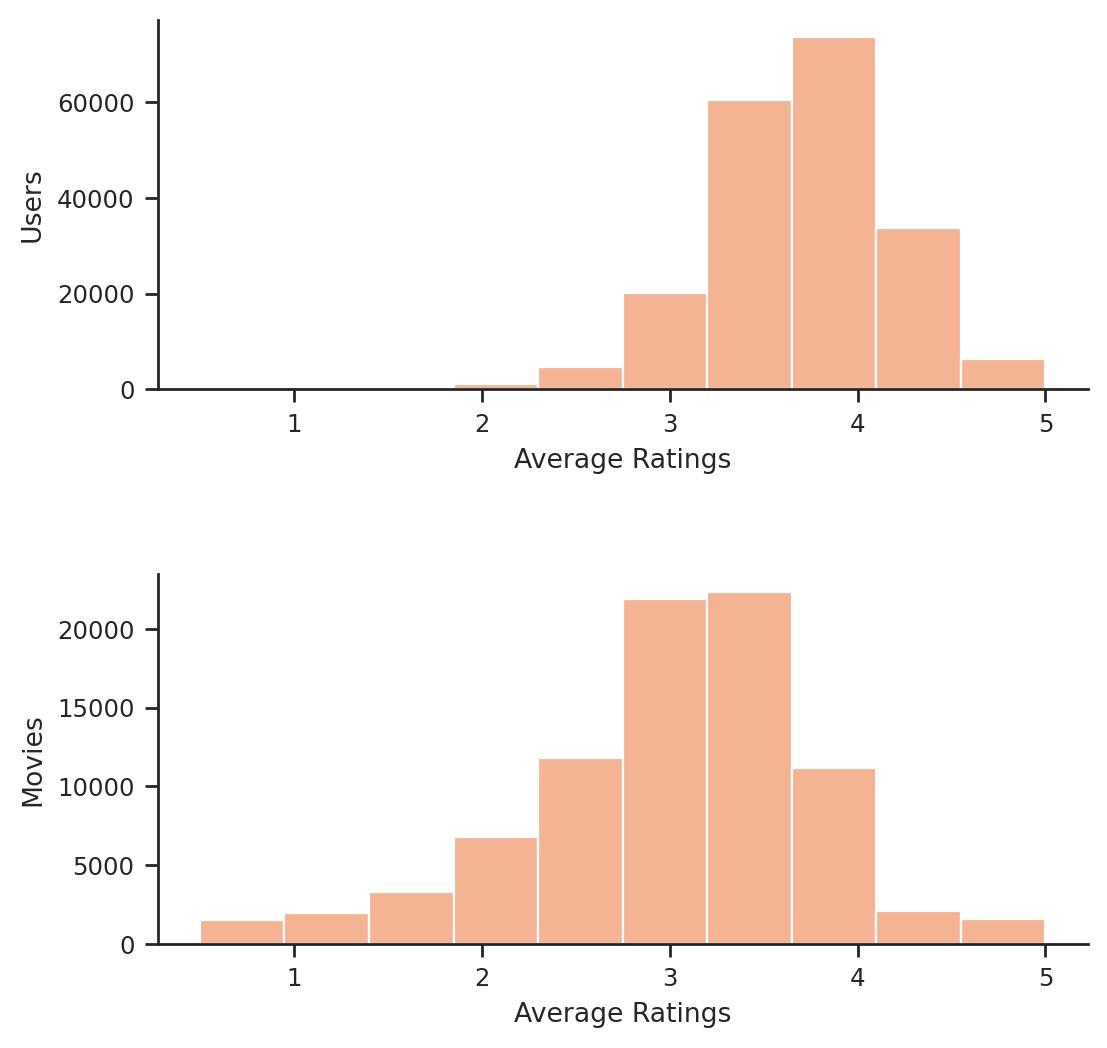

In [ ]:
ratings_users_mean = ratings.groupby(by=['userId'])['rating'].mean()
ratings_movies_mean = ratings.groupby(by=['movieId'])['rating'].mean()

fig, axes = plt.subplot_mosaic(
    [
        ["first"],
        ['second']
    ],
    gridspec_kw=dict(hspace=0.5,wspace=0.2),figsize=(6,6)
    )

axes["first"].hist(ratings_users_mean,bins=10)
axes['second'].hist(ratings_movies_mean,bins=10)

axes['second'].set_ylabel('Movies')
axes['first'].set_ylabel('Users')

axes['second'].set_xlabel('Average Ratings')
axes['first'].set_xlabel('Average Ratings')
# axes['text1'].text(0.2,0.5,r'$U_{max(\hat{r})}=$')
# axes['text2'].text(0.2,0.5,r'$U_{min(\hat{r})}=$')
# fig.suptitle("Distribution of average ratings per user and movies")

plt.savefig('/content/drive/MyDrive/Colab Notebooks/aai/plots/meanratings_u_m.pdf',dpi=500,format='pdf')
plt.show()

In [ ]:
#make new array with users and thier average ratings
user_ratings = ratings.groupby(by=['userId'])['rating'].mean()
plt.bar(user_ratings.index,height=user_ratings)
plt.show()

In [ ]:
movies_seen =ratings.groupby(by=['userId'])['movieId'].count()
print(movies_seen.max())

user_seen = ratings.groupby(by=['movieId'])['userId'].count()
print(user_seen.max())

33332
102929


In [ ]:
movies.loc[movies['movieId']==318]

movieId                             title       genres
314      318  Shawshank Redemption, The (1994)  Crime|Drama

In [ ]:
movies_per_user = ratings.groupby('userId').size().reset_index(name='movie_count')
top_user = movies_per_user.sort_values('movie_count', ascending=False).head(1)
print(top_user)


users_per_movie = ratings.groupby('movieId').size().reset_index(name='user_count')
top_user = users_per_movie.sort_values('user_count', ascending=False).head(1)
print(top_user)

        userId  movie_count
175324  175325        33332
     movieId  user_count
314      318      102929


In [ ]:
movies_seen[175325]


np.int64(33332)

In [ ]:
x= movies_seen[movies_seen['movieId']== 33332]
x

np.int64(141)

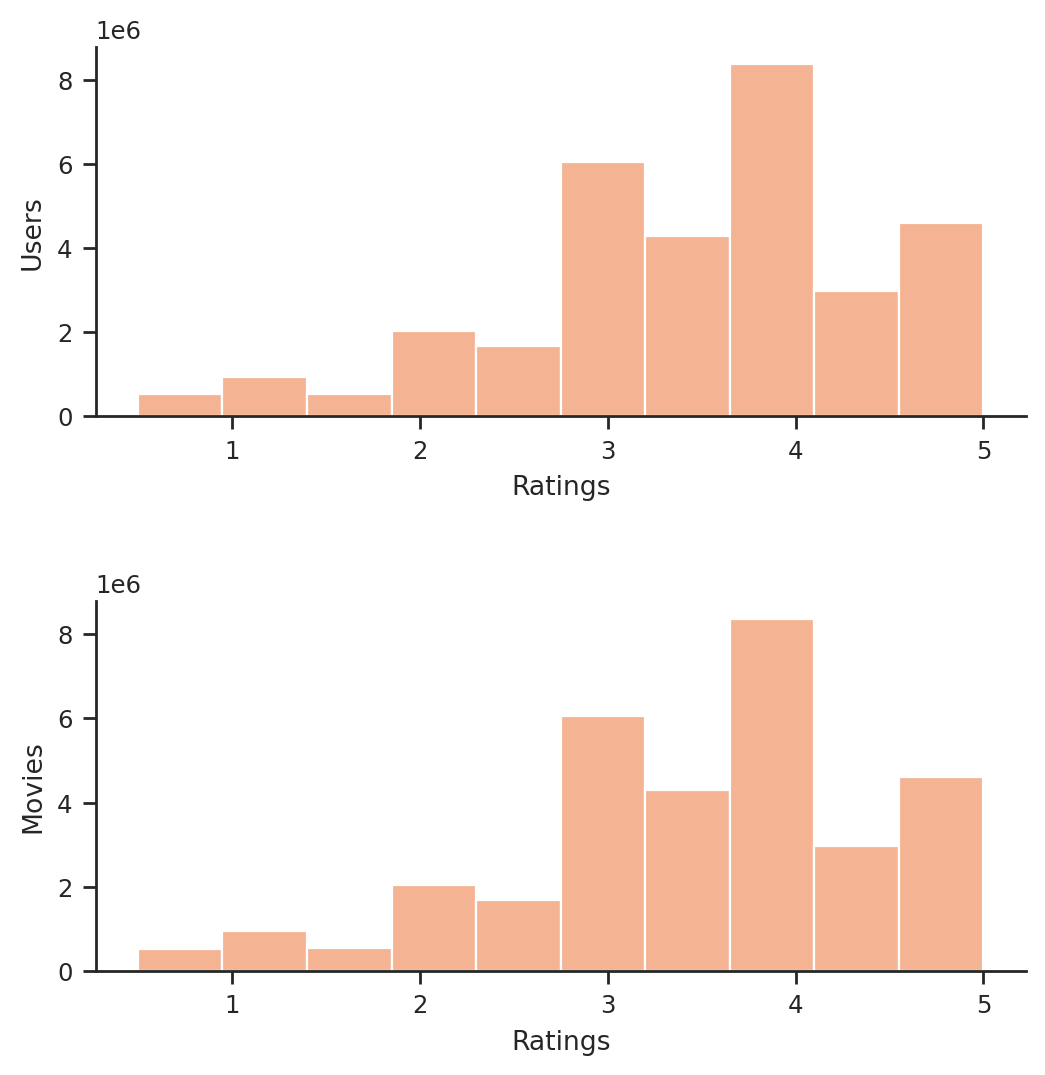

In [ ]:
ratings_users = ratings.groupby(by=['rating'])['userId'].count()
ratings_movies = ratings.groupby(by=['rating'])['movieId'].count()

fig, axes = plt.subplot_mosaic(
    [
        ["first"],
        ["second"]
    ],
    gridspec_kw=dict(hspace=0.5,wspace=0),figsize=(6,6)
    )

axes["first"].hist(ratings_users.index,weights=ratings_users,bins=10)
axes['second'].hist(ratings_movies.index, weights=ratings_movies,bins=10)
axes['first'].set_xlabel('Ratings')
axes['second'].set_xlabel('Ratings')

axes['first'].set_ylabel('Users')
axes['second'].set_ylabel('Movies')
# axes['text1'].text(0.2,0.5,rf'$Max({{U}}_{{m}})=${movies_seen[175325]} Movies')
# axes['text2'].text(0.1,0.9,r'$Max({{M}}_{{u}})=Shawshank$')
# fig.suptitle("Distribution of rating counts per user and movies")

plt.savefig('/content/drive/MyDrive/Colab Notebooks/aai/plots/ratings_u_m.pdf',dpi=500,format='pdf')
plt.show()

In [ ]:
ratings_users

rating
0.5     525132
1.0     946675
1.5     531063
2.0    2028622
2.5    1685386
3.0    6054990
3.5    4290105
4.0    8367654
4.5    2974000
5.0    4596577
Name: userId, dtype: int64

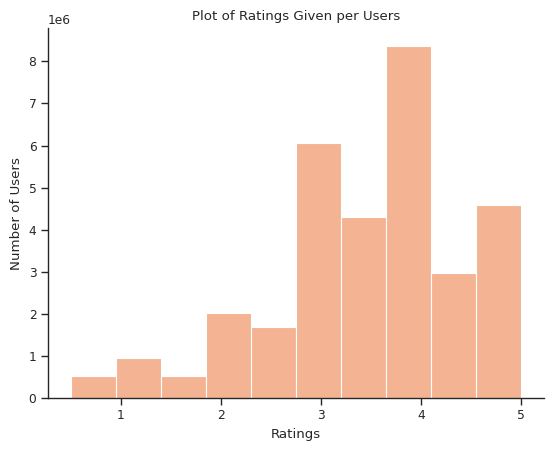

In [ ]:
#ratings per user
ratings_users = ratings.groupby(by=['rating'])['userId'].count()
plt.hist(ratings_users.index,weights=ratings_users,bins=10)
plt.title("Plot of Ratings Given per Users")
plt.xlabel("Ratings")
plt.ylabel("Number of Users")
#plt.yscale('log')
plt.show()

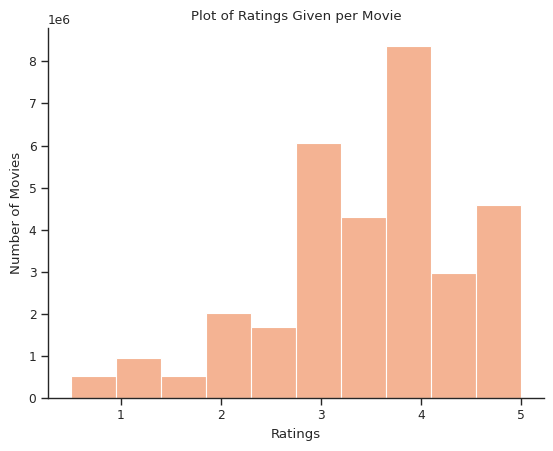

In [ ]:
#ratings per movie
ratings_movies = ratings.groupby(by=['rating'])['movieId'].count()
plt.hist(ratings_movies.index, weights=ratings_movies)
plt.title("Plot of Ratings Given per Movie")
plt.xlabel("Ratings")
plt.ylabel("Number of Movies")
plt.show()

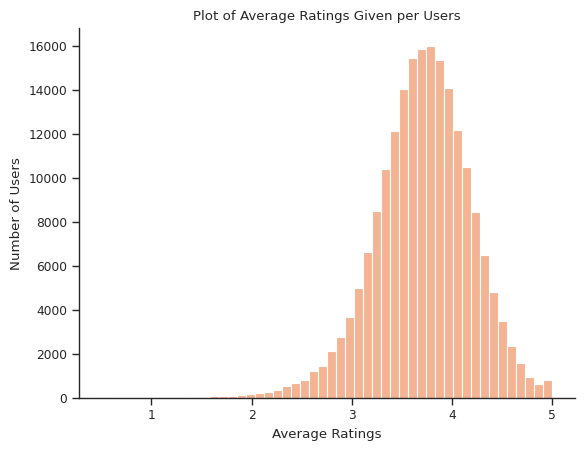

In [ ]:
# mean rating per user
mean_user_rating = ratings.groupby(by=['userId'])['rating'].mean()
plt.hist(mean_user_rating,bins=50)
plt.title("Plot of Average Ratings Given per Users")
plt.xlabel("Average Ratings")
plt.ylabel("Number of Users")
#plt.yscale('log')
#plt.text(1,20,f"max rating = {mean_user_rating.max()}")
plt.show()

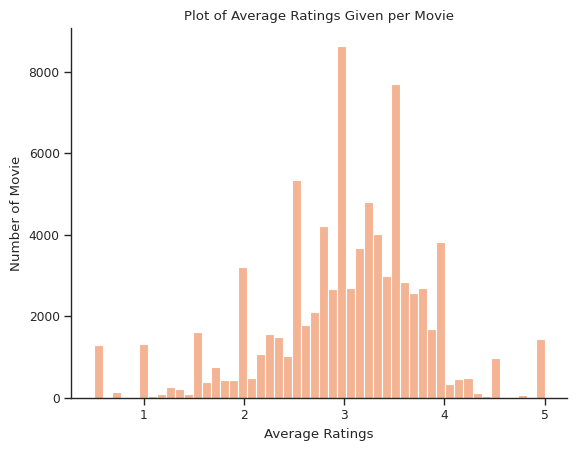

In [ ]:
# mean rating per user
mean_movie_rating = ratings.groupby(by=['movieId'])['rating'].mean()
plt.hist(mean_movie_rating,bins=50)
plt.title("Plot of Average Ratings Given per Movie")
plt.xlabel("Average Ratings")
plt.ylabel("Number of Movie")
plt.show()

In [ ]:
mean_movie_rating.min()

0.5

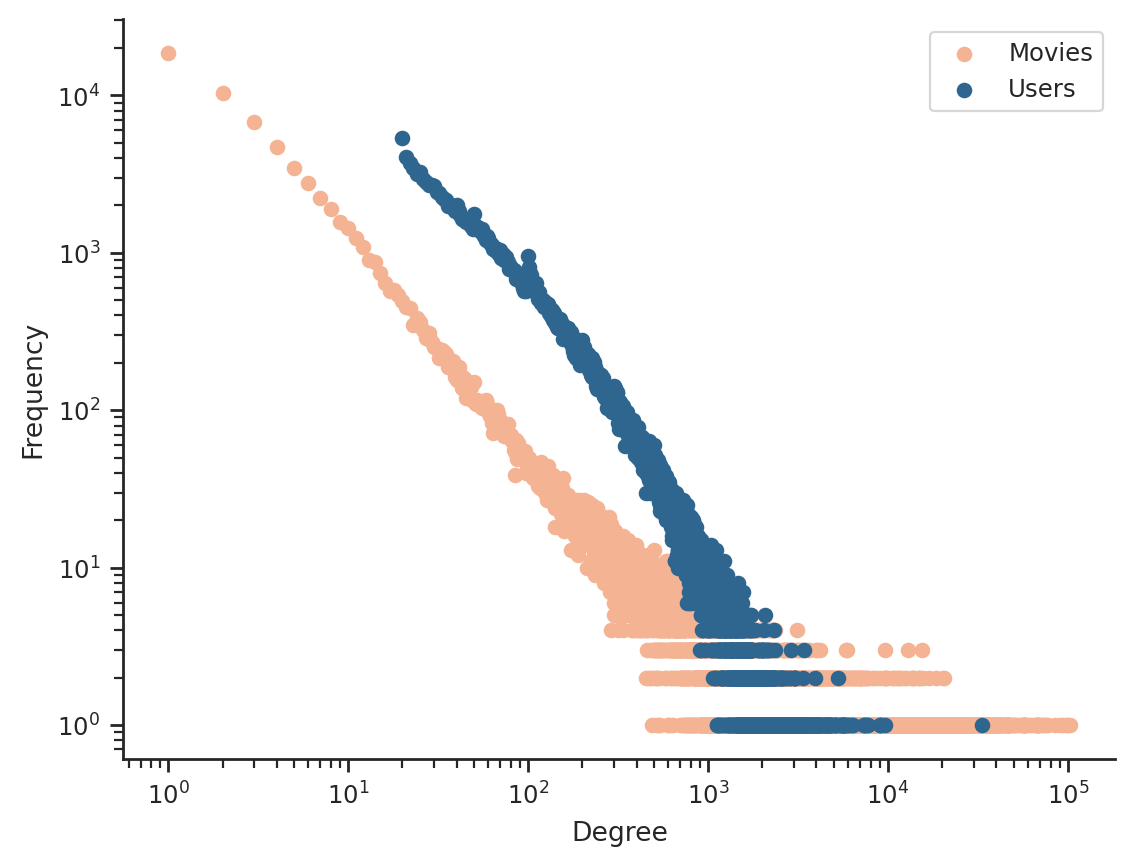

In [ ]:
#power law movies
movie_pl = ratings['movieId'].to_numpy()
user_pl = ratings['userId'].to_numpy()

_,movie_freq=np.unique(movie_pl,return_counts=True)
movie_ranks,movie_frequencies = np.unique(movie_freq, return_counts=True)

_, user_freq = np.unique(user_pl,return_counts=True)
user_ranks,user_frequencies= np.unique(user_freq,return_counts=True)

plt.scatter(movie_ranks,movie_frequencies,label = "Movies")

plt.scatter(user_ranks,user_frequencies, label = "Users")

plt.xscale('log')
plt.xlabel('Degree')
plt.yscale('log')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/aai/plots/power_law.pdf',dpi=500,format='pdf')
plt.show()